<a href="https://colab.research.google.com/github/paulagmar/ArticSeaIceMasking_ComputerVision/blob/main/ComputerVision_SatelliteClassificationSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project Computer Vision**



# **Table of Contents**
---

* [1. Introduction](#intro)
* [2. In-depth dataset analysis](#data)
  * [2.1 Files format](#format)
  * [2.2 Patch distribution](#patch)
  * [2.3 Masks](#masks)
    * [Mask format](#format)
    * [SIGIRD-3 format simplification](#simpl)
  * [2.4 Images and masks display](#display)
  * [2.5 Conclusion of the analysis](#conclusion)
* [3. Class unbalance, data augmentation and model definition](#des)
  * [3.1 Loading and displaying data](#load)
    * [Information for class unbalance](#unba)
  * [3.2 Train, validation and test sets](#sets)
    * [Basic train-validation-test split](#split)
    * [Split with oversampling](#over)
  * [3.3 Data augmentation](#da)
  * [3.4 Model definition and training](#model)
  * [3.5 Loading weights](#weights)


In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image

import tensorflow as tf

# Removing unnecesary text in output cells
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

'''gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])
    #logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,")#, len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Los dispositivos lógicos deben configurarse antes de inicializar las GPUs
    print(e)'''


'gpus = tf.config.list_physical_devices(\'GPU\')\nif gpus:\n  try:\n    tf.config.set_logical_device_configuration(\n        gpus[0],\n        [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])\n    #logical_gpus = tf.config.list_logical_devices(\'GPU\')\n    print(len(gpus), "Physical GPUs,")#, len(logical_gpus), "Logical GPUs")\n  except RuntimeError as e:\n    # Los dispositivos lógicos deben configurarse antes de inicializar las GPUs\n    print(e)'

In [ ]:
from google.colab import drive
import os, sys
drive.mount('/content/drive')

# Set the necessary directories
img_dir = '/content/drive/MyDrive/Colab Notebooks/CV/Final/Images/'

img_filenames = os.listdir(img_dir)
img_names = [s.split('.')[0] for s in img_filenames]

img_ext = '.jpg'

Mounted at /content/drive


# **1. Introduction**

In this project we are going to test and compare different approaches for the training of models based on the kaggle dataset: [Artic Sea Ice Image Masking](https://www.kaggle.com/datasets/alexandersylvester/arctic-sea-ice-image-masking). Note that parts of the code are inspired on the [proposed code implementation](https://www.kaggle.com/code/alexandersylvester/sea-ice-segmentation-u-net) and it is not a novel model proposed by us.

This dataset is focused in sea ice concentration estimation based on Sentinel-2 radar images. This satellite mission uses optical sensing and captures information in different spectral bands. The use of different combinations of these bands enhance specific contents in the images, for example, some combinations provides better visualization of forests and plants agrupations, while others are more suitable for ice detection.

Applying Deep Learning into Earth Observation is a very active topic in research fields, and this particular analysis will be usefull for the study performed as Master's Thesis for one of us.

Along this notebook, we will delve into the dataset composition and characteristics, and we will check how data augmentation techniques affects into the inference capabilities of the proposed model.

# **2. In-depth dataset analysis**

The dataset contains **3392 Sentinel-2 images** (therefore, with a resolution of 10 m/px) of the Hudson Bay, in the canadian Artic, taken between 01/01/2016 and 31/07/2018. The provided images are in a fake color composition (composed by bands 8, 4 and 3), since RGB compositions are obtained using bands 4, 3 and 2. Every image has its corresponding mask, showing its Sea Ice Concentracion (SIC).



![image.png](https://drive.google.com/uc?export=view&id=18mSogU59_HbkqdgJmkxWBR4GuLDAnqLP)




<center><img src='https://drive.google.com/file/d/14J36u2ufxy8fvhY-XuHKoL1TCbngPOL9/view?usp=sharing' width=400 /></center>




## 2.1 Files format

The names of the files follow the structure: _P[patch id]-yyyymmddhh_.

Therefore, "P0-2016042417" is an image from patch 0 taken on 24th April 2016 at 17:00h. With "patch" we refer to the Bay section where the image comes from. We can see the patch distribution in the following figure. There are some of them with no data:


![image.png](https://drive.google.com/uc?export=view&id=14J36u2ufxy8fvhY-XuHKoL1TCbngPOL9)


### **Data origin**

* Satellite images: Sentinelhub's API, through [EO-Learn](https://eo-learn.readthedocs.io/en/latest/) library.

* Ice charts: [National Snow and Ice Data Centre](https://nsidc.org/data/search#keywords=sea+ice/sortKeys=score,,desc/facetFilters=%257B%257D/pageNumber=1/itemsPerPage=25).

## 2.2 Patch distribution

Patches appear numbered from 0 to 581, from left to right and from the top to the bottom. Let's see how the 3392 images are distributed along these patches.

In [ ]:
patches = [0] * 582

for img_name in img_names:
    num_parche = int(img_name.split('-')[0][1:])
    patches[num_parche] += 1

non_empty_patches = [x for x in patches if x != 0]
empty_patches = [i for i, x in enumerate(patches) if x == 0]

print(f'Number of images: {sum(patches)}')
print(f'\nNumber of patches without data: {len(empty_patches)}. Patches wothout data are between numbers {min(empty_patches)} and {max(empty_patches)}.')
print(f'\nIn those patches with data, the average number of images is {np.round(np.mean(non_empty_patches), 2)}±{np.round(np.std(non_empty_patches), 2)}.')

Number of images: 3392

Number of patches without data: 124. Patches wothout data are between numbers 365 and 581.

In those patches with data, the average number of images is 7.41±3.9.


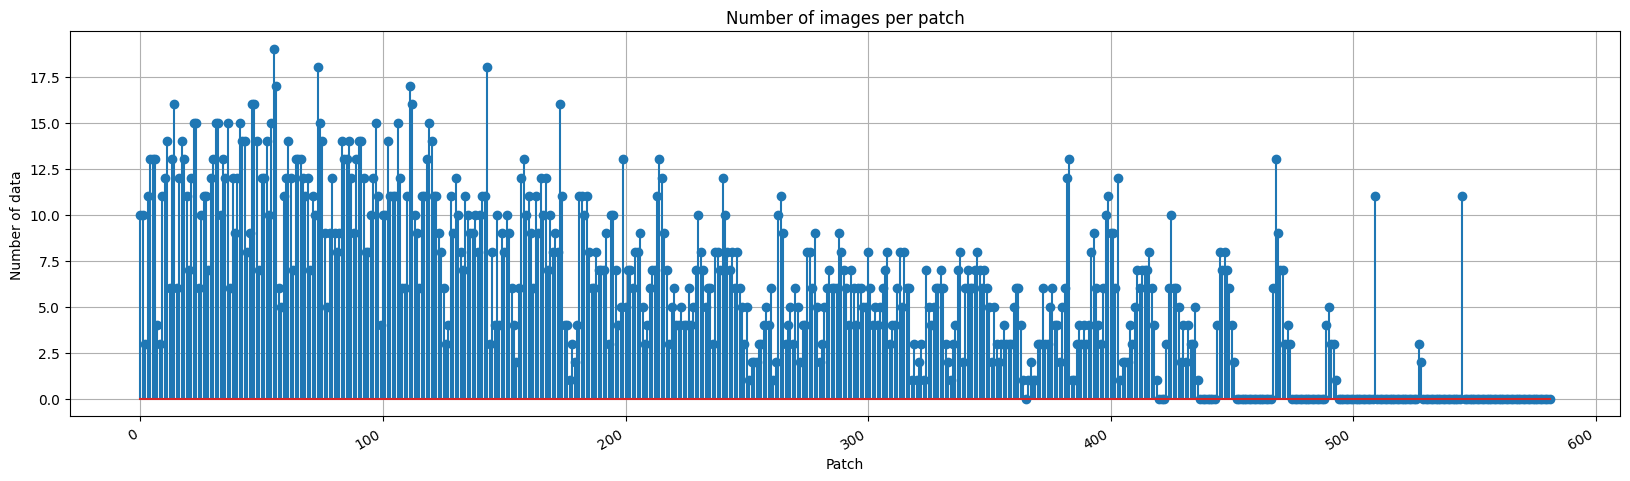

In [ ]:
plt.figure(figsize=(20,5))
plt.stem(range(len(patches)), patches)
plt.xlabel('Patch')
plt.ylabel('Number of data')
plt.title('Number of images per patch')
plt.xticks(rotation=30, ha='right')
plt.grid()
plt.show()

As we can see there are more images from the west part of the bay, while the ones without data are concentrated in the east, the external part. In the pathches where we have information we got an average of 7 images per patch, eventhough the number is variable between them.


## 2.3 Masks

### **Masks format**

Masks are codified based on the following format: [SIGRID-3](https://library.wmo.int/doc_num.php?explnum_id=9270). In particular, we are interested the following chart, which indicates the definition of the sea ice concentration corresponding to each code:

![image.png](https://drive.google.com/uc?export=view&id=1ZNVIhv93Au0PfQ-K9TtY0cXzMq5h_zCq)

Based on this information, we establish a dictionary to assign each value in the mask to its corresponding concentration. Initially, we will keep the same distribution as the reference notebook, where **the concentration is assigned in the range [0-7], where 0 indicates the absence of ice, 6 indicates the maximum concentration, and 7 indicates land presence or missing data**.

In [ ]:
mask_lib = {1:0, #<1/10 (open water)
            2:0, #bergy water
            10:1, #1/10
            12:1, #1/10-2/10
            13:1, #1/10-3/10
            20:1, #2/20
            23:1, #2/20-3/10
            24:2, #2/20-4/10
            30:2, #...
            34:2,
            35:2,
            40:2,
            45:2,
            46:3,
            50:3,
            55:0, #ice free
            56:3,
            57:3,
            60:3,
            67:3,
            68:4, #...
            70:4, #7/10
            78:4, #7/10-8/10
            79:4, #7/10-9/10
            80:4, #8/10
            89:4, #8/10-9/10
            81:5, #8/10-10/10
            90:5, #9/10
            91:5, #9/10-10/10
            92:6, #10/10 - fast ice
            99:7, #unknown - there is nothing in this class for this dataset
            100:7 #land
           }

Now we are going to analize the values distribution in SIGRID-3 format:

In [ ]:
# Number of diferent possible values in the original mask
n_original_classes = len(mask_lib.keys())
print(f'Number of different values in the originalen SIGRID-3 format of the mask: {n_original_classes}')

Number of different values in the originalen SIGRID-3 format of the mask: 32


We define a function to count the number of repetitions of each possible value of the mask and then we will plot a dataframe with this information.

In [ ]:
# Function to calculate the value counts over all pixels in an image (fed in as a numpy array)
def bincount_2d(arr, max_int):
    counts_full = [0 for n in range(max_int)]
    for row in arr:
        counts = np.bincount(row).tolist()  #get the counts for the row
        pad = [0 for n in range(max_int-len(counts))]
        counts = counts + pad               #add extra zeroes to account for colors above the max in the row
        counts_full = [counts_full[n] + counts[n] for n in range(max_int)]
    return(counts_full)

In [ ]:
mask_dir = '/content/drive/MyDrive/Colab Notebooks/CV/Final/Masks/'
mask_ext = '-mask.png'

In [ ]:
orig_dat = []  # list to hold information on the original masks

for img_name in img_names:
    name = mask_dir + img_name

    # importing the image
    mask = Image.open(name + mask_ext)

    # converting mask
    mask = np.array(mask)  # convert to numpy. Shape (306, 357)

    # update dataframe
    name = img_name.split('-')
    d = [img_name,
         name[0][1:],  # patch id
         name[1][0:4],  # year
         name[1][4:6],  # month
         name[1][6:8],  # day
         name[1][8:10]]  # hour

    counts_orig = bincount_2d(mask, np.max(list(mask_lib.keys()))+1)  # values counts of the class of ice over all pixels in the original image. +1 so that enters in range
    counts_orig = [i for j,i in enumerate(counts_orig) if j in list(mask_lib.keys())]

    d_orig = d.copy()
    d_orig.extend(counts_orig)
    orig_dat.append(d_orig)

# Create a list of column names based on the possible initial mask values
column_names = ['val_' + str(key) for key in mask_lib.keys()]

# Modify the column names list to include the first 6 columns
column_names = ['name', 'patch_id', 'year', 'month', 'day', 'hour'] + column_names

# Create the original mask DataFrame with the updated column names
orig_mask_df = pd.DataFrame(orig_dat, columns=column_names)

orig_mask_df.head(5) # Show some examples

name patch_id  year month day hour  val_1   val_2  val_10  \
0  P413-2017052315      413  2017    05  23   15      0       0       0   
1  P330-2017111316      330  2017    11  13   16      0  109242       0   
2  P371-2016050115      371  2016    05  01   15      0       0       0   
3  P314-2018032016      314  2018    03  20   16      0       0       0   
4  P344-2017061816      344  2017    06  18   16      0       0       0   

   val_12  ...  val_78  val_79  val_80  val_89  val_81  val_90  val_91  \
0       0  ...       0       0       0       0       0       0  108995   
1       0  ...       0       0       0       0       0       0       0   
2       0  ...       0       0       0       0       0       0   86395   
3       0  ...       0       0       0       0       0       0   15059   
4       0  ...       0       0       0       0       0       0    2882   

   val_92  val_99  val_100  
0       0       0        0  
1       0       0        0  
2    6302       0    15327  
3   21020       0    73163  
4     340       0    80698  

[5 rows x 38 columns]

In [ ]:
# Suma las ocurrencias de cada valor en las columnas del DataFrame orig_mask_df
counts = orig_mask_df.iloc[:, 6:].sum()

# Convierte la serie 'counts' en un DataFrame y reinicia el índice
counts_df = counts.reset_index()

# Renombra las columnas del nuevo DataFrame
counts_df.columns = ['mask_value', 'frequency']

# Ordena el DataFrame de mayor a menor según la columna 'frequency'
sorted_counts_df = counts_df.sort_values(by='frequency', ascending=False)

# Quitamos las filas correspondientes a valores que no aparecen
sorted_counts_df = sorted_counts_df.drop(sorted_counts_df[sorted_counts_df['frequency'] == 0].index)

sorted_counts_df

mask_value  frequency
28     val_91  176219831
31    val_100   84138584
0       val_1   26791075
29     val_92   16276646
1       val_2   13805323
5      val_20    9764081
14     val_50    8364506
27     val_90    7949918
21     val_70    6633804
24     val_80    6433641
8      val_30    1913371
2      val_10     302651
11     val_40     182402
18     val_60      45867

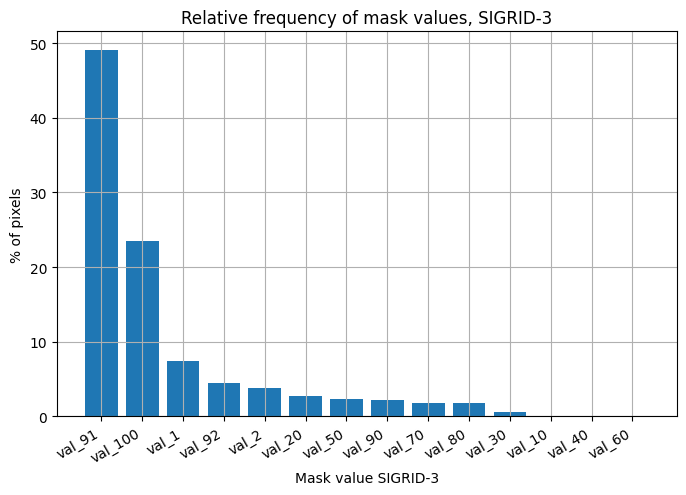

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(sorted_counts_df['mask_value'], (sorted_counts_df['frequency']/sorted_counts_df['frequency'].sum())*100)
plt.xlabel('Mask value SIGRID-3')
plt.ylabel('% of pixels')
plt.title('Relative frequency of mask values, SIGRID-3')
plt.xticks(rotation=30, ha='right')
plt.grid()
plt.show()

As we can see, the most frequent value for the pixels is '91' (concentration between 9-10/10) with almost 50%, which is significantly higher than the value '92' that indicates a concentration of 10/10. The second most frequent values are '100', which corresponds to solid ground, and '01', representing open sea (or concentrations less than 1/10).

### **SIGRID-3 format-simplification**

Now, we will map these values from the SIGRID-3 format to concentration percentages numbered from 0-6, with value 7 for land areas or missing data, as we had defined in the dictionary at the beginning of the notebook.

In [ ]:
# Auxiliar code for:
# Matching to the simplified format
def map_mask(mask, lib):
    new_mask = mask.copy()
    for key, val in lib.items():#map the elements of the array to their new values according to the library
        new_mask[mask==key]=val
    return new_mask

# Colormap for the mask
n_colors=8
ice_colors = n_colors-1
jet = plt.get_cmap('jet', ice_colors)
newcolors = jet(np.linspace(0, 1, ice_colors))
black = np.array([[0, 0, 0, 1]])
white = np.array([[1, 1, 1, 1]])
newcolors = np.concatenate((newcolors, black), axis=0) #land will be black
cmap = ListedColormap(newcolors)

In [ ]:
# convert all mask files from SIGRID 3 format to simplified
new_mask_ext = '-mask-mod.png'
dat = []   #list that will hold information on the masks

output_dir = '/content/drive/MyDrive/Colab Notebooks/CV/Final/outputs/'

In [ ]:
# Asegúrate de que la carpeta "outputs" exista, si no, créala
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for img_name in img_names:
    name = mask_dir + img_name
    # importing the image
    mask = Image.open(name + mask_ext)

    # converting mask
    mask = np.array(mask) #convert to numpy
    new_mask = map_mask(mask, mask_lib)#map values

    # update dataframe
    name = img_name.split('-')
    d = [img_name,
         name[0][1:],  #patch id
         name[1][0:4], #year
         name[1][4:6], #month
         name[1][6:8], #day
         name[1][8:10]]#hour

    counts = bincount_2d(new_mask, n_colors) #values counts of the class of ice over all pixels in the image
    d.extend(counts)
    dat.append(d)

    # exporting the image
    new_mask = Image.fromarray(new_mask)#convert back to image
    new_mask.save(output_dir + img_name + new_mask_ext, 'PNG')

# Actualiza el directorio y la extensión de las máscaras
mask_dir = output_dir
mask_ext = new_mask_ext

#create dataframe of mask information
mask_df = pd.DataFrame(dat, columns = ['name', 'patch_id', 'year', 'month', 'day', 'hour',
                            'conc_0', 'conc_1', 'conc_2', 'conc_3', 'conc_4', 'conc_5', 'conc_6',
                            'conc_land'])

In [ ]:
# Asegúrate de que la carpeta "outputs" exista, si no, créala
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for img_name in img_names:
    name = mask_dir + img_name
    # importing the image
    mask = Image.open(name + mask_ext)

    # converting mask
    mask = np.array(mask) #convert to numpy
    new_mask = map_mask(mask, mask_lib)#map values

    # update dataframe
    name = img_name.split('-')
    d = [img_name,
         name[0][1:],  #patch id
         name[1][0:4], #year
         name[1][4:6], #month
         name[1][6:8], #day
         name[1][8:10]]#hour

    counts = bincount_2d(new_mask, n_colors) #values counts of the class of ice over all pixels in the image
    d.extend(counts)
    dat.append(d)

    # exporting the image
    new_mask = Image.fromarray(new_mask)#convert back to image
    new_mask.save(output_dir + img_name + new_mask_ext, 'PNG')

# Actualiza el directorio y la extensión de las máscaras
mask_dir = output_dir
mask_ext = new_mask_ext

#create dataframe of mask information
mask_df = pd.DataFrame(dat, columns = ['name', 'patch_id', 'year', 'month', 'day', 'hour',
                            'conc_0', 'conc_1', 'conc_2', 'conc_3', 'conc_4', 'conc_5', 'conc_6',
                            'conc_land'])

In [ ]:
class_max = mask_df.iloc[:,6:-1].idxmax(axis=1) #category of the most common class in the image. We will stratify our train test split by this
class_max.value_counts()

conc_5    2652
conc_0     881
conc_6     507
conc_4     167
conc_1     133
conc_3     103
conc_2      36
dtype: int64

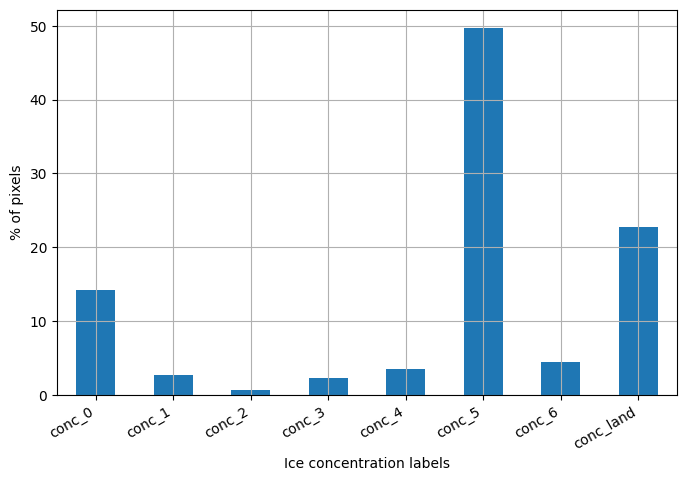

In [ ]:
#plot realtive frequency of ice concentrations in images
counts = mask_df.iloc[:,6:].sum()
norm = counts.sum()
probs = counts/norm*100

plt.figure(figsize=(8,5))
probs.plot(kind='bar')
plt.ylabel('% of pixels')
plt.xlabel('Ice concentration labels')
plt.xticks(rotation=30, ha='right')
plt.grid()

Most of the pixels in the final masks have a concentration value of 5/6. We have assigned this value to concentrations 8-10/10, 9/10, and 9/-10/10, while the value 6/6 is exclusively used for a concentration of 10/10. The second most common value represents ground (7), followed by open water (0).

## 2.4 Images and masks display


We define auxiliary functions to read the corresponding files.

In [ ]:
IMG_SIZE = (256, 256)

#function to read image and mask from file
def read_image_and_mask(image_name):
    image = tf.io.read_file(img_dir + image_name + img_ext)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_dir + image_name + mask_ext)
    mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
    mask = tf.image.resize(mask, IMG_SIZE)
    mask = tf.cast(mask, tf.uint8)
    return image, mask


def display(display_list):
    fig, axs = plt.subplots(nrows=1, ncols = len(display_list), figsize=(15, 6))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        axs[i].set_title(title[i])
        if i==0:
            axs[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            msk = axs[i].imshow(display_list[i], cmap = cmap, vmin=0, vmax=n_colors-1)
        axs[i].axis('off')

    #plot colorbar
    cbar = fig.colorbar(msk, ax=axs, location='right')
    tick_locs = (np.arange(n_colors) + 0.5)*(n_colors-1)/n_colors#new tick locations so they are in the middle of the colorbar
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([f'{i}/6' if i < 7 else 'Land/no data' for i in range(n_colors)])
    plt.show()

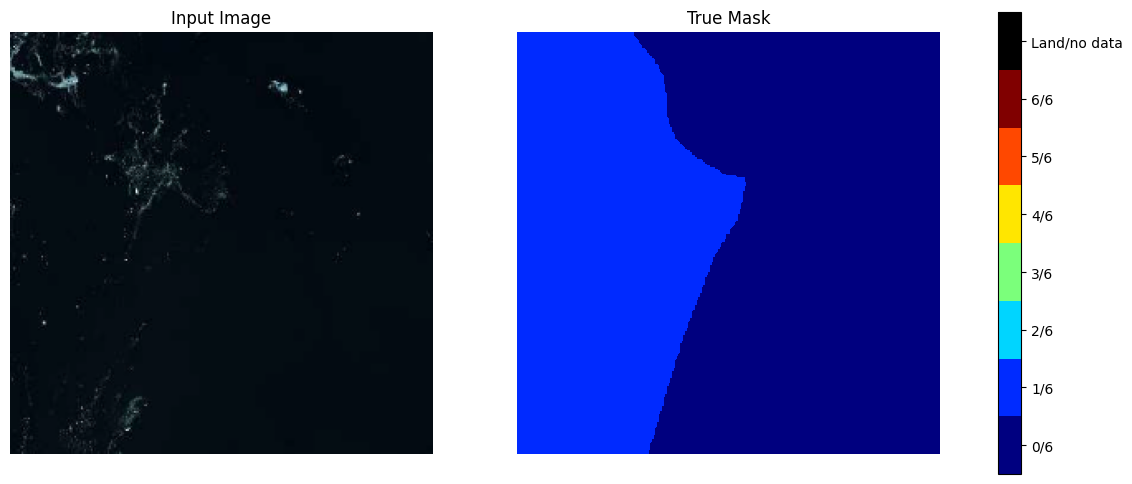

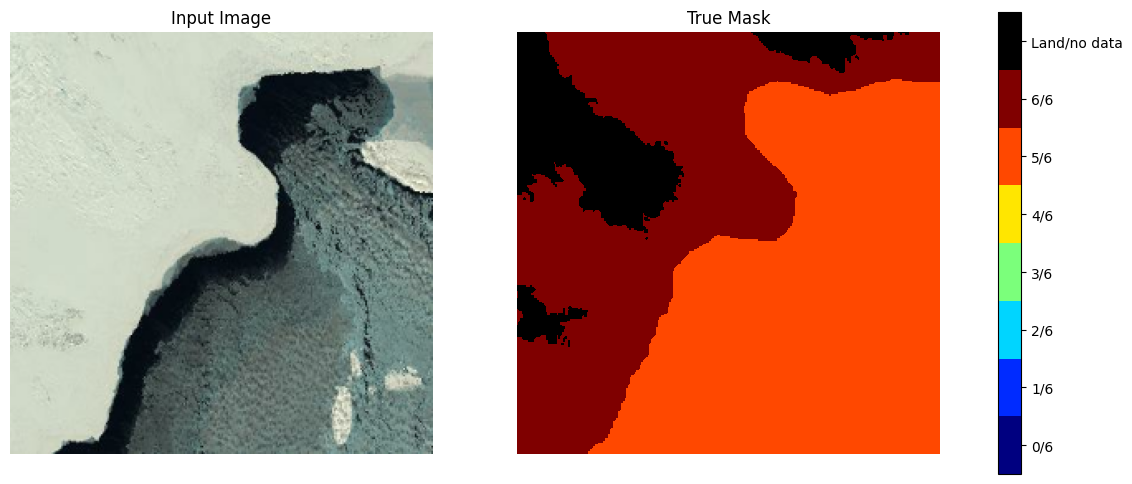

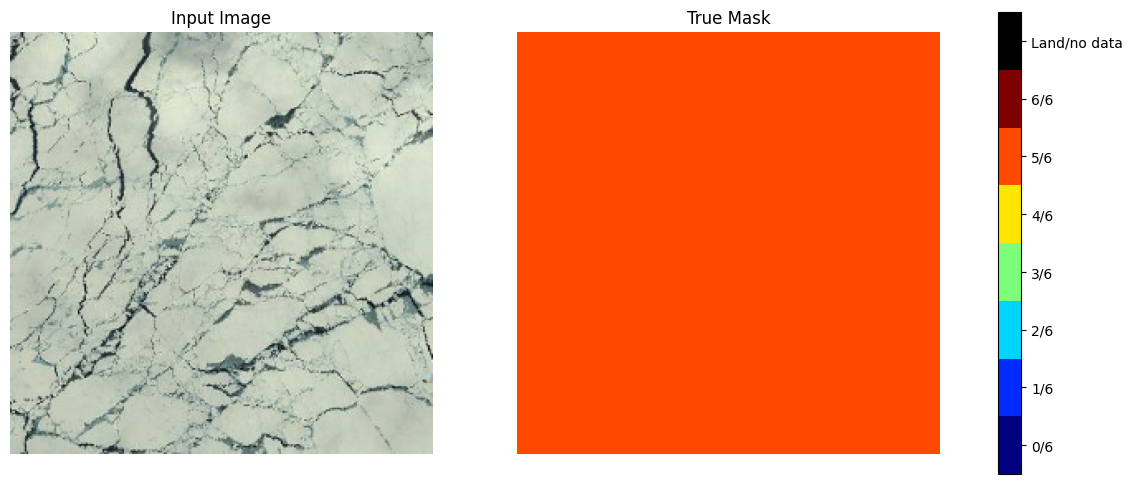

In [ ]:
ds_complete = tf.data.Dataset.from_tensor_slices((img_names))#read filenames
ds_complete = ds_complete.map(read_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE) #convert filenames to stream of images/masks
ds_random = ds_complete.shuffle(buffer_size=len(img_names)).take(3)

# Display random samples
for image, mask in ds_random:
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])


## 2.5 Conclusion of the analysis

We have 3392 Sentinel-2 images (bands 8, 4, 3) along with their corresponding masks indicating the ice concentration in SIGRID-3 format. The images are reshaped to 256x256 to standardize their size as input to the following models. We can simplify the encoding of the mask by representing the ice concentration on a scale of 0-6 and indicating the presence of land or missing data with the value 7

# **3. Data augmentation, class unbalance and model definition**

In this section, we will define the proposed model. We eill repeat the initial imports so that we can directly execute this part of the code without running previous cells.

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
#import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image

import tensorflow as tf

# Removing unnecesary text in output cells
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [ ]:
from google.colab import drive
import os, sys
drive.mount('/content/drive')

img_dir = '/content/drive/MyDrive/Colab Notebooks/CV/Final/Images/'
mask_dir = '/content/drive/MyDrive/Colab Notebooks/CV/Final/outputs/'
img_ext = '.jpg'
mask_ext = '-mask-mod.png'

IMG_SIZE = (256, 256)

# Set the necessary directories
img_dir = '/content/drive/MyDrive/Colab Notebooks/CV/Final/Images/'

img_filenames = os.listdir(img_dir)
img_names = [s.split('.')[0] for s in img_filenames]


Mounted at /content/drive


## 3.1 Loading and displaying data

In [ ]:
#function to read image and mask from file
def read_image_and_mask(image_name):
    image = tf.io.read_file(img_dir + image_name + img_ext)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_dir + image_name + mask_ext)
    mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
    mask = tf.image.resize(mask, IMG_SIZE)
    mask = tf.cast(mask, tf.uint8)
    return image, mask

# Function to calculate the value counts over all pixels in an image (fed in as a numpy array)
def bincount_2d(arr, max_int):
    counts_full = [0 for n in range(max_int)]
    for row in arr:
        counts = np.bincount(row).tolist()  #get the counts for the row
        pad = [0 for n in range(max_int-len(counts))]
        counts = counts + pad               #add extra zeroes to account for colors above the max in the row
        counts_full = [counts_full[n] + counts[n] for n in range(max_int)]
    return(counts_full)

def display(display_list):
    fig, axs = plt.subplots(nrows=1, ncols = len(display_list), figsize=(12, 5))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        axs[i].set_title(title[i])
        if i==0:
            axs[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            msk = axs[i].imshow(display_list[i], cmap = cmap, vmin=0, vmax=n_colors-1)
        axs[i].axis('off')

    #plot colorbar
    cbar = fig.colorbar(msk, ax=axs, location='right')
    tick_locs = (np.arange(n_colors) + 0.5)*(n_colors-1)/n_colors#new tick locations so they are in the middle of the colorbar
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([f'{i}/6' if i < 7 else 'Land/no data' for i in range(n_colors)])
    plt.show()

# For future representations
n_colors=8
ice_colors = n_colors-1
jet = plt.get_cmap('jet', ice_colors)
newcolors = jet(np.linspace(0, 1, ice_colors))
black = np.array([[0, 0, 0, 1]])
white = np.array([[1, 1, 1, 1]])
newcolors = np.concatenate((newcolors, black), axis=0) #land will be black
cmap = ListedColormap(newcolors)

Check that data has correctly been loaded.

In [ ]:
# Load data ------------------
ds_complete = tf.data.Dataset.from_tensor_slices((img_names))#read filenames
ds_complete = ds_complete.map(read_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE) #convert filenames to stream of images/masks

ds_random = ds_complete.shuffle(buffer_size=len(img_names)).take(3)

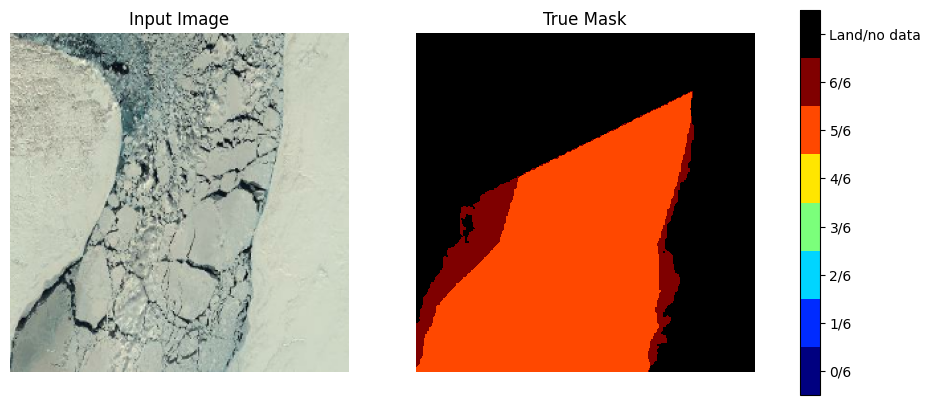

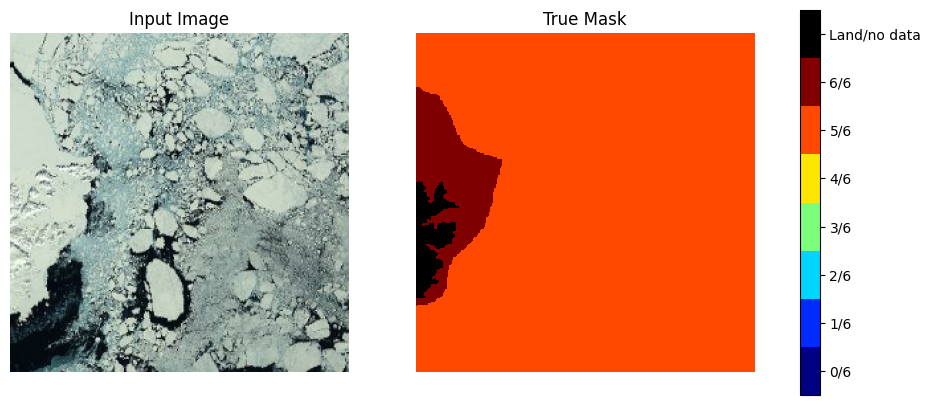

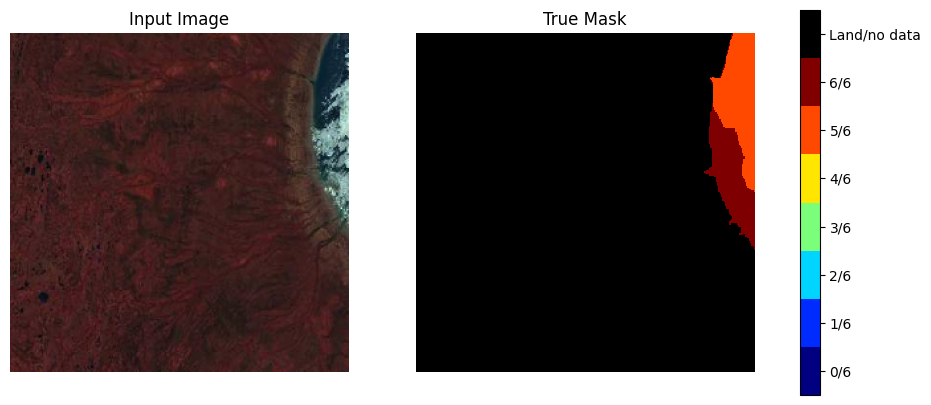

In [ ]:
# Display random samples ~ 20 min
for image, mask in ds_random:
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

### Information for class unbalance

Get information about the most frequent label in each image. We will use this information in the stratified split and in the oversampling of less frequent classes.

In [ ]:
dat = []   #list that will hold information on the masks

for img_name in img_names:
    name = mask_dir + img_name
    # importing the image
    mask = Image.open(name + mask_ext)
    # converting mask
    mask = np.array(mask) #convert to numpy
    # update dataframe
    name = img_name.split('-')
    d = [img_name,
         name[0][1:],  #patch id
         name[1][0:4], #year
         name[1][4:6], #month
         name[1][6:8], #day
         name[1][8:10]]#hour

    counts = bincount_2d(mask, n_colors) #values counts of the class of ice over all pixels in the image
    d.extend(counts)
    dat.append(d)

#create dataframe of mask information
mask_df = pd.DataFrame(dat, columns = ['name', 'patch_id', 'year', 'month', 'day', 'hour',
                            'conc_0', 'conc_1', 'conc_2', 'conc_3', 'conc_4', 'conc_5', 'conc_6',
                            'conc_land'])

In [ ]:
mask_df['conc_minor'] = mask_df[['conc_1', 'conc_2', 'conc_3', 'conc_4']].sum(axis=1)

n_pixels = mask_df.iloc[:, 6:].sum(axis=1)  # total number of pixels in each image

mask_df['fraction_minor'] = mask_df['conc_minor'] / n_pixels  # fraction of minor concentrations in each image

over_sample_names = mask_df[mask_df['fraction_minor'] > 0.3]  # we will over-sample these images of the under-represented classes
over_sample_names = over_sample_names['name'].values.tolist()

In [ ]:
mask_df.drop(['conc_minor'], axis='columns', inplace=True)

class_max = mask_df.iloc[:,6:-1].idxmax(axis=1) #category of the most common class in the image. We will stratify our train test split by this
class_max.value_counts()

conc_5       1756
conc_land     849
conc_0        480
conc_4        109
conc_1         83
conc_3         59
conc_6         44
conc_2         12
dtype: int64

## 3.2 Train, validation and test sets

### Basic train-validation-test split

Let's define a initial tran and validation split. Since there is a significant class unbalance, we will perform a stratified split based on the most frequent label in each mask.

In [ ]:
from sklearn.model_selection import train_test_split

# train/validation split. Note relevance of class_max
names = mask_df['name'].values
train_names, validation_names, train_max, validation_max = train_test_split(img_names, class_max,
                                                                            train_size=0.7, test_size=0.3,
                                                                            random_state=0, stratify=class_max)

print(f'Train set size: {len(train_names)}, validation/test set size: {len(validation_names)}. In total, {len(train_names)+len(validation_names)} images.')

Train set size: 2374, validation/test set size: 1018. In total, 3392 images.


In [ ]:
img_names[0]

'P413-2017052315'

In [ ]:
validation_names[0]

'P471-2018041715'

In [ ]:
dat_train = []

for img_name in train_names:
    name = mask_dir + img_name
    # importing the image
    mask = Image.open(name + mask_ext)
    # converting mask
    mask = np.array(mask) #convert to numpy
    # update dataframe
    name = img_name.split('-')
    d = [img_name,
         name[0][1:],  #patch id
         name[1][0:4], #year
         name[1][4:6], #month
         name[1][6:8], #day
         name[1][8:10]]#hour

    counts = bincount_2d(mask, n_colors) #values counts of the class of ice over all pixels in the image
    d.extend(counts)
    dat_train.append(d)

#create dataframe of mask information
mask_df_train = pd.DataFrame(dat_train, columns = ['name', 'patch_id', 'year', 'month', 'day', 'hour',
                            'conc_0', 'conc_1', 'conc_2', 'conc_3', 'conc_4', 'conc_5', 'conc_6',
                            'conc_land'])

print('Data distribution according to its most common label:')
class_max_train = mask_df_train.iloc[:,6:-1].idxmax(axis=1) #category of the most common class in the image. We will stratify our train test split by this
class_max_train.value_counts()

Data distribution according to its most common label:


conc_5    1388
conc_0     462
conc_6     273
conc_4      94
conc_1      80
conc_3      61
conc_2      16
dtype: int64

In [ ]:
TRAIN_LENGTH = int(len(train_names))
VAL_LENGTH = int(len(validation_names))
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((train_names))#read filenames
ds_train = ds_train.map(read_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE) #convert filenames to stream of images/masks
#ds_train = ds_train.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) #convert filenames to stream of images/masks
train_dataset = ds_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
ds_val = tf.data.Dataset.from_tensor_slices((validation_names))#read filenames
ds_val = ds_val.map(read_image_and_mask) #convert filenames to stream of images/masks
val_dataset = ds_val.batch(BATCH_SIZE)

### Split with training oversampling.

**Oversampling of the unfrequent classes**

In [ ]:
from sklearn.model_selection import train_test_split

# train/validation split. Note relevance of class_max
names = mask_df['name'].values
train_names, validation_names, train_max, validation_max = train_test_split(img_names, class_max,
                                                                            train_size=0.7, test_size=0.3,
                                                                            random_state=0, stratify=class_max)

# add over-sampled images to the train dataset
train_over_sample_names = np.array([name for name in train_names if name in over_sample_names])
N_over_sample = int(len(train_names)/1.5) #number of additional samples to add, not every sample will be added
ids = np.arange(len(train_over_sample_names))
choices = np.random.choice(ids, N_over_sample)#an additional set of images to add on to the train names

print(f'Tamaño inicial train set: {len(train_names)}, Tamaño validation/test set: {len(validation_names)}. En total, {len(train_names)+len(validation_names)} imágenes.')

dat_train = []

for img_name in train_names:
    name = mask_dir + img_name
    # importing the image
    mask = Image.open(name + mask_ext)
    # converting mask
    mask = np.array(mask) #convert to numpy
    # update dataframe
    name = img_name.split('-')
    d = [img_name,
         name[0][1:],  #patch id
         name[1][0:4], #year
         name[1][4:6], #month
         name[1][6:8], #day
         name[1][8:10]]#hour

    counts = bincount_2d(mask, n_colors) #values counts of the class of ice over all pixels in the image
    d.extend(counts)
    dat_train.append(d)

#create dataframe of mask information
mask_df_train = pd.DataFrame(dat_train, columns = ['name', 'patch_id', 'year', 'month', 'day', 'hour',
                            'conc_0', 'conc_1', 'conc_2', 'conc_3', 'conc_4', 'conc_5', 'conc_6',
                            'conc_land'])

print('\nDistribución de los datos iniciales de entrenamiento según su clase predominante:')
class_max_train = mask_df_train.iloc[:,6:-1].idxmax(axis=1) #category of the most common class in the image. We will stratify our train test split by this
class_max_train.value_counts()

Tamaño inicial train set: 2374, Tamaño validation/test set: 1018. En total, 3392 imágenes.

Distribución de los datos iniciales de entrenamiento según su clase predominante:


conc_5    1388
conc_0     465
conc_6     270
conc_4      96
conc_1      81
conc_3      58
conc_2      16
dtype: int64

In [ ]:
added_train_names = train_over_sample_names[choices].tolist() # get the samples of our train so as to oversample based on our criteria (>0.3 of minoritary class)
train_names.extend(added_train_names)

print(f'Tamaño actualizado del train set: {len(train_names)}')

dat_train = []   #list that will hold information on the masks

for img_name in train_names:
    name = mask_dir + img_name
    # importing the image
    mask = Image.open(name + mask_ext)
    # converting mask
    mask = np.array(mask) #convert to numpy
    # update dataframe
    name = img_name.split('-')
    d = [img_name,
         name[0][1:],  #patch id
         name[1][0:4], #year
         name[1][4:6], #month
         name[1][6:8], #day
         name[1][8:10]]#hour

    counts = bincount_2d(mask, n_colors) #values counts of the class of ice over all pixels in the image
    d.extend(counts)
    dat_train.append(d)

#create dataframe of mask information
mask_df_train = pd.DataFrame(dat_train, columns = ['name', 'patch_id', 'year', 'month', 'day', 'hour',
                            'conc_0', 'conc_1', 'conc_2', 'conc_3', 'conc_4', 'conc_5', 'conc_6',
                            'conc_land'])

class_max_train = mask_df_train.iloc[:,6:-1].idxmax(axis=1) #category of the most common class in the image. We will stratify our train test split by this
class_max_train.value_counts()

Tamaño actualizado del train set: 3956


conc_5    1521
conc_4     697
conc_0     526
conc_1     479
conc_3     373
conc_6     270
conc_2      90
dtype: int64

As we can see, now we got a higher number of images where the predominant classes are 1, 2, 3, 4

In [ ]:
TRAIN_LENGTH = int(len(train_names))
VAL_LENGTH = int(len(validation_names))
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((train_names))#read filenames
ds_train = ds_train.map(read_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE) #convert filenames to stream of images/masks
#ds_train = ds_train.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) #convert filenames to stream of images/masks
train_dataset = ds_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
ds_val = tf.data.Dataset.from_tensor_slices((validation_names))#read filenames
ds_val = ds_val.map(read_image_and_mask) #convert filenames to stream of images/masks
val_dataset = ds_val.batch(BATCH_SIZE)

## 3.3 Data augmentation

In order to include data augmentation, we will also take into account the percentaje of pixels that represent a concentration of 5/6. We will filter those images, and then include a random horizontal and vertical flip, both with a probability of 50%.



In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((train_names))#read filenames
ds_train = ds_train.map(read_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE) #convert filenames to stream of images/masks

In [ ]:
# Auxiliar function for fliping
def filter_images(image, mask):
    percentage_5 = tf.cast(tf.math.count_nonzero(mask == 5), dtype=tf.float32) / (tf.cast(tf.size(mask), dtype=tf.float32))
    return percentage_5 < 0.6

def augment_image(image, mask):

    n = tf.random.uniform([], 0, 1)
    if n < 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    n = tf.random.uniform([], 0, 1)
    if n < 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    return image, mask


ds_filtered = ds_train.filter(filter_images)
ds_augmented = ds_filtered.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

combined_dataset = ds_train.concatenate(ds_augmented)
combined_dataset = combined_dataset.shuffle(BUFFER_SIZE)

train_dataset_augmented = combined_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() #
train_dataset_augmented = train_dataset_augmented.prefetch(buffer_size=tf.data.AUTOTUNE)

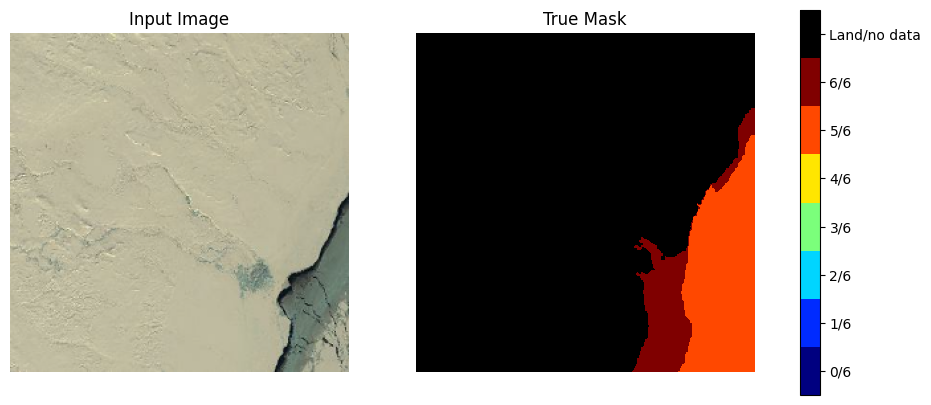

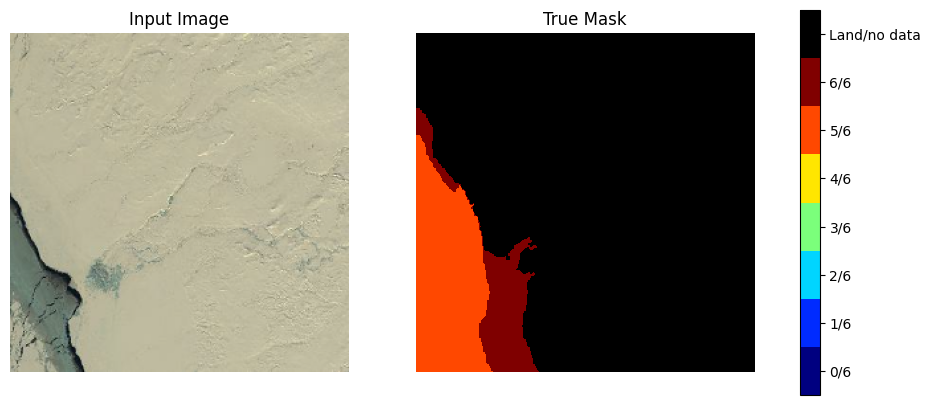

In [ ]:
for image, mask in ds_train.take(3):
    original_image, original_mask = image, mask
display([image, mask])

# Apply augment_image to the specific example from ds_train
augmented_image, augmented_mask = augment_image(original_image, original_mask)
display([augmented_image, augmented_mask])

In [ ]:
# Number of data in initial train dataset (after oversampling)
count_tr = 0
for _ in ds_train:
    count_tr += 1
print("Original ds_train has", count_tr, "images.")

# Number of augmented data
count_da = 0
for _ in ds_augmented:
    count_da += 1
print("Augmented dataset ds_augmented has", count_da, "new images.")
print(f"Then we now have {count_tr + count_da} images in the train set.")

Original ds_train has 2374 images.
Augmented dataset ds_augmented has 1265 new images.
Then we now have 3639 images in the train set.


## 3.3 Model definition

In [ ]:
# -------------- Versión ---------------
#model_version = 'vDefault'
model_version = 'v1'
#model_version = 'vDefaultNoAugmentation'

Este es el código del modelo original, por limitaciones de recursos usaremos la arquitectura simplificada.

In [ ]:
'''from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras import Model
def get_unet():
    inputs = Input(shape=[IMG_SIZE[0], IMG_SIZE[1], 3])
    conv1 = Conv2D(32, 3, 1, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, 1, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(64, 3, 1, activation='relu', padding='same')(drop1)
    conv2 = Conv2D(64, 3, 1, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(128, 3, 1, activation='relu', padding='same')(drop2)
    conv3 = Conv2D(128, 3, 1, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(256, 3, 1, activation='relu', padding='same')(drop3)
    conv4 = Conv2D(256, 3, 1, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(512, 3, 1, activation='relu', padding='same')(drop4)
    conv5 = Conv2D(512, 3, 1, activation='relu', padding='same')(conv5)

    up6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([up6, conv4], axis=3)
    drop6 = Dropout(0.5)(merge6)
    conv6 = Conv2D(256, 3, 1, activation='relu', padding='same')(drop6)
    conv6 = Conv2D(256, 3, 1, activation='relu', padding='same')(conv6)

    up7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([up7, conv3], axis=3)
    drop7 = Dropout(0.5)(merge7)
    conv7 = Conv2D(128, 3, 1, activation='relu', padding='same')(drop7)
    conv7 = Conv2D(128, 3, 1, activation='relu', padding='same')(conv7)

    up8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([up8, conv2], axis=3)
    drop8 = Dropout(0.5)(merge8)
    conv8 = Conv2D(64, 3, 1, activation='relu', padding='same')(drop8)
    conv8 = Conv2D(64, 3, 1, activation='relu', padding='same')(conv8)

    up9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([up9, conv1], axis=3)
    drop9 = Dropout(0.5)(merge9)
    conv9 = Conv2D(32, 3, 1, activation='relu', padding='same')(drop9)
    conv9 = Conv2D(32, 3, 1, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_colors, 1, 1, activation='softmax')(conv9) #softmax converts the output to a list of probabilities that must sum to 1

    model = Model(inputs=inputs, outputs=conv10)
    return model

model = get_unet()
#tf.keras.utils.plot_model(model, show_shapes=True)'''

"from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout\nfrom tensorflow.keras import Model\ndef get_unet():\n    inputs = Input(shape=[IMG_SIZE[0], IMG_SIZE[1], 3])\n    conv1 = Conv2D(32, 3, 1, activation='relu', padding='same')(inputs)\n    conv1 = Conv2D(32, 3, 1, activation='relu', padding='same')(conv1)\n    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)\n    drop1 = Dropout(0.5)(pool1)\n\n    conv2 = Conv2D(64, 3, 1, activation='relu', padding='same')(drop1)\n    conv2 = Conv2D(64, 3, 1, activation='relu', padding='same')(conv2)\n    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)\n    drop2 = Dropout(0.5)(pool2)\n\n    conv3 = Conv2D(128, 3, 1, activation='relu', padding='same')(drop2)\n    conv3 = Conv2D(128, 3, 1, activation='relu', padding='same')(conv3)\n    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)\n    drop3 = Dropout(0.5)(pool3)\n\n    conv4 = Conv2D(256, 3, 1, activation='relu', padding='same')(drop3)\n    conv4 = Conv2D(256, 3, 1, act

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


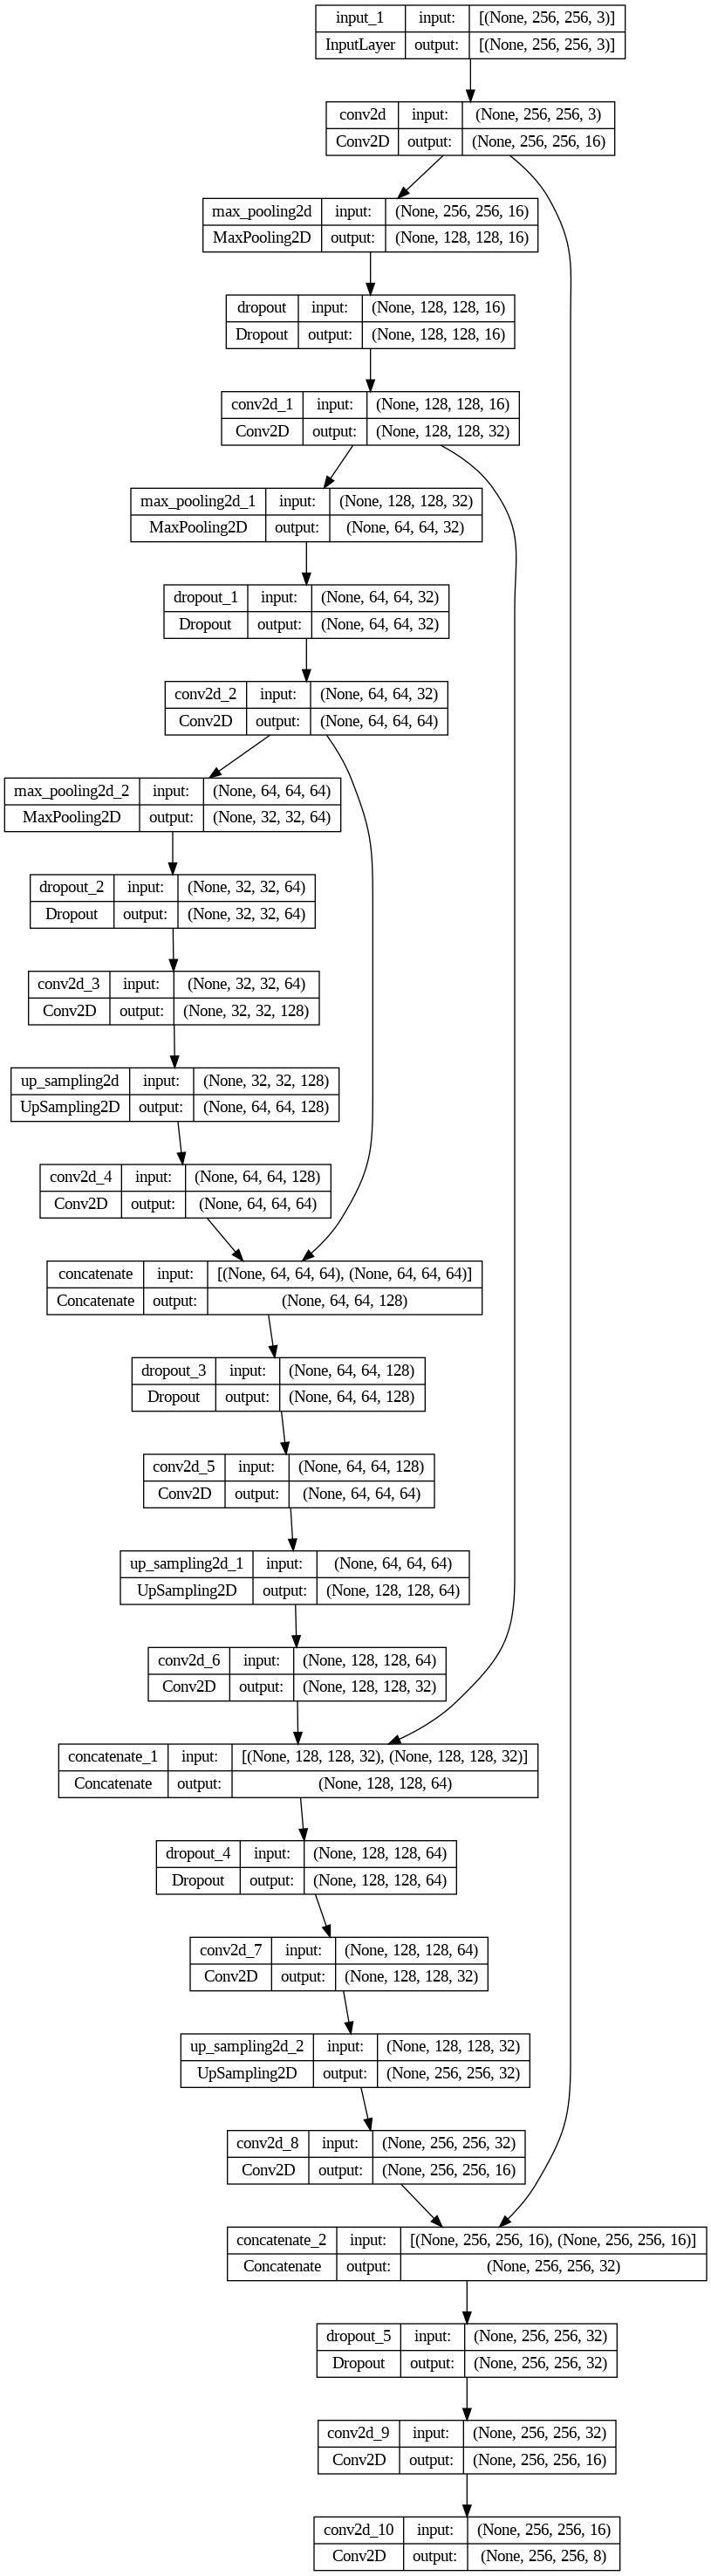

In [ ]:
# SIMPLIFICACIÓN
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras import Model
def get_unet():
    inputs = Input(shape=[IMG_SIZE[0], IMG_SIZE[1], 3])
    conv1 = Conv2D(16, 3, 1, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(32, 3, 1, activation='relu', padding='same')(drop1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(64, 3, 1, activation='relu', padding='same')(drop2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(128, 3, 1, activation='relu', padding='same')(drop3)

    up5 = Conv2D(64, 3, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge5 = concatenate([up5, conv3], axis=3)
    drop5 = Dropout(0.5)(merge5)
    conv5 = Conv2D(64, 3, 1, activation='relu', padding='same')(drop5)

    up6 = Conv2D(32, 3, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([up6, conv2], axis=3)
    drop6 = Dropout(0.5)(merge6)
    conv6 = Conv2D(32, 3, 1, activation='relu', padding='same')(drop6)

    up7 = Conv2D(16, 3, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([up7, conv1], axis=3)
    drop7 = Dropout(0.5)(merge7)
    conv7 = Conv2D(16, 3, 1, activation='relu', padding='same')(drop7)

    #conv8 = Conv2D(1, 1, activation='softmax')(conv7)
    conv8 = Conv2D(n_colors, 1, 1, activation='softmax')(conv7) #softmax converts the output to a list of probabilities that must sum to 1

    model = Model(inputs=inputs, outputs=conv8)

    return model


model = get_unet()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#function to generate a mask from the model predictions
def create_mask(pred_mask, ele=0):
    pred_mask = tf.argmax(pred_mask, axis=-1)#use the highest proabbaility class as the prediction
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[ele]

#helper functions to plot image, mask, and predicted mask while training
def show_predictions(dataset=None, num=1, ele=0):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[ele], mask[ele], create_mask(pred_mask, ele)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

#function to display loss during training
def plot_loss_acc(loss, val_loss, epoch):#, acc, val_acc, epoch):

    epochs = range(epoch+1)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

    ax.plot(epochs, loss, 'r', label='Training loss')
    ax.plot(epochs, val_loss, 'bo', label='Validation loss')
    ax.set_title('Training and Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss Value')
    ax.legend()
    plt.show()

#callback to clear output and show predictions
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.loss = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)

        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])

        show_predictions()
        plot_loss_acc(self.loss, self.val_loss, epoch)

#callback to reduce learning rate when loss plateaus
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=8, verbose=1,)

#Define IoU metric (by stack overflow user HuckleberryFinn)
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# Create a callback that saves the model's weights
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/CV/Final/training/" + model_version + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)

## 3.4 Model training

In [ ]:
model=get_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy', UpdatedMeanIoU(num_classes=n_colors)])

EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks=[DisplayCallback(), lr_callback, cp_callback])



NameError: ignored

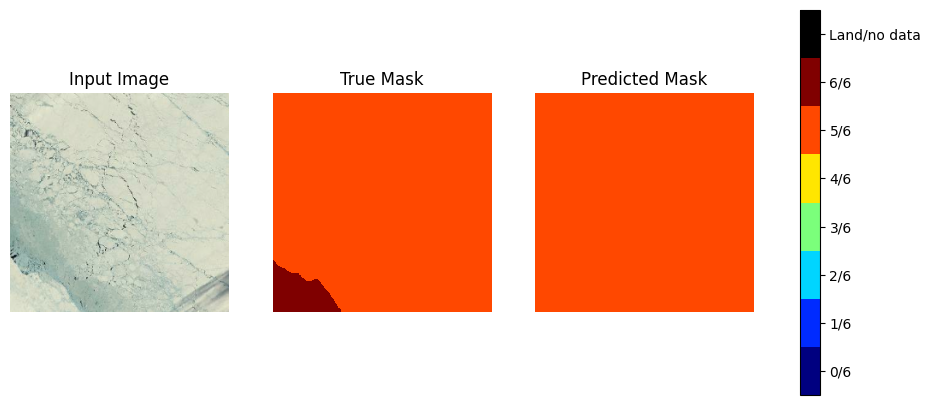

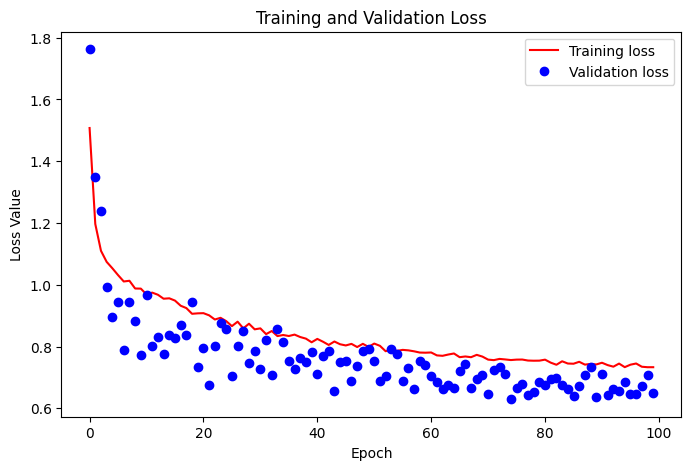

In [ ]:
#train model
model=get_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy', UpdatedMeanIoU(num_classes=n_colors)])

EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks=[DisplayCallback(), lr_callback, cp_callback])



In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

ax[0].plot(epochs, loss, 'r', label='Training')
ax[0].plot(epochs, val_loss, 'bo', label='Validation')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss Value')
ax[0].legend()

IoU_key = list(model_history.history.keys())[2]
acc = model_history.history[IoU_key]
val_acc = model_history.history['val_'+IoU_key]

ax[1].plot(epochs, acc, 'r', label='Training')
ax[1].plot(epochs, val_acc, 'bo', label='Validation')
ax[1].set_title('Training and Validation IoU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('IoU Value')
ax[1].legend()
plt.show()

In [ ]:
model.load_weights(checkpoint_dir + '/cp-0051.ckpt')
scores = model.evaluate(val_dataset, verbose=0)
print('Final Model Validation Scores')
print('Loss: {:.3f}'.format(scores[0]))
print('Accuracy: {:.3f}'.format(scores[1]))
print('IoU: {:.3f}'.format(scores[2]))

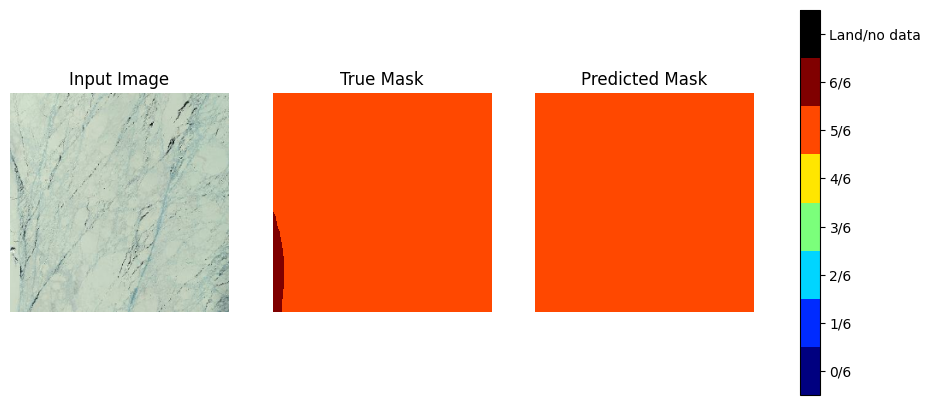

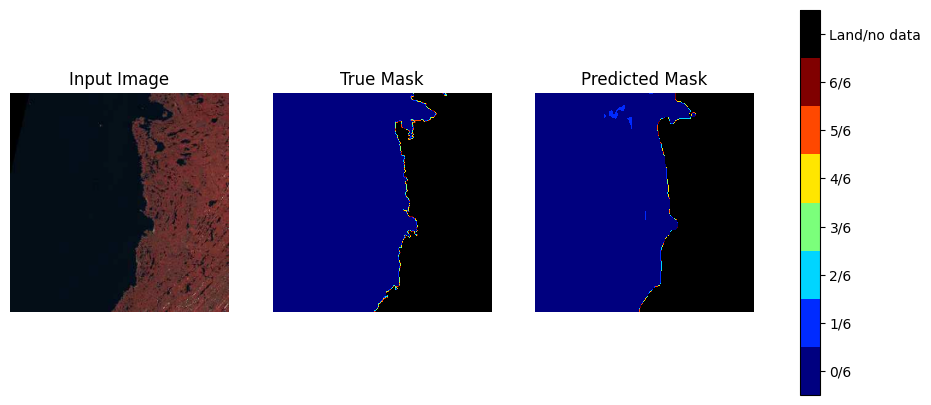

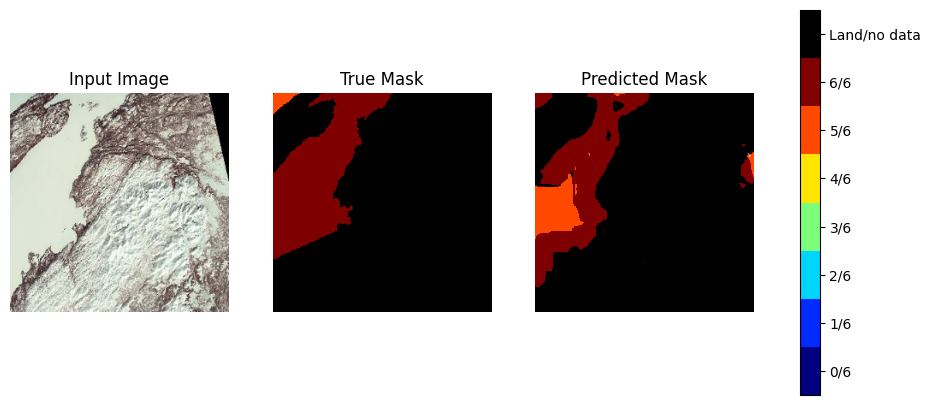

In [ ]:
random_val_dataset = val_dataset.shuffle(buffer_size=len(validation_names)).take(3)

show_predictions(random_val_dataset, num=4, ele=3)


## 3.5 Loading weigths

### Upsampling

Con el código actual, el mejor checkpoint se corresponde con el de la últina época, el checkpoint 100:

In [ ]:
#load weights for checkpoint 100
# print(os.listdir(checkpoint_dir))

model.load_weights(checkpoint_dir + '/cp-0100.ckpt')
#model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['sparse_categorical_accuracy', UpdatedMeanIoU(num_classes=8)])

scores = model.evaluate(val_dataset, verbose=0)
print('Final Model Validation Scores')
print('Loss: {:.3f}'.format(scores[0]))
print('Accuracy: {:.3f}'.format(scores[1]))
print('IoU: {:.3f}'.format(scores[2]))

Final Model Validation Scores
Loss: 0.591
Accuracy: 0.806
IoU: 0.401


1/1 [==============================] - 2s 2s/step


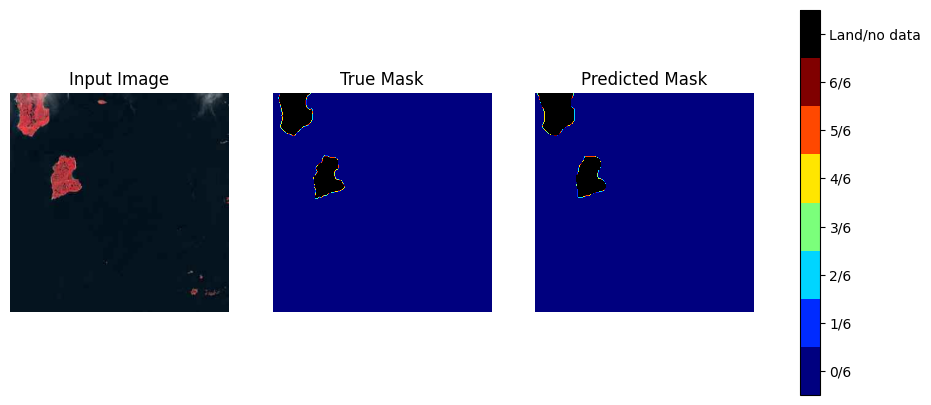

1/1 [==============================] - 2s 2s/step


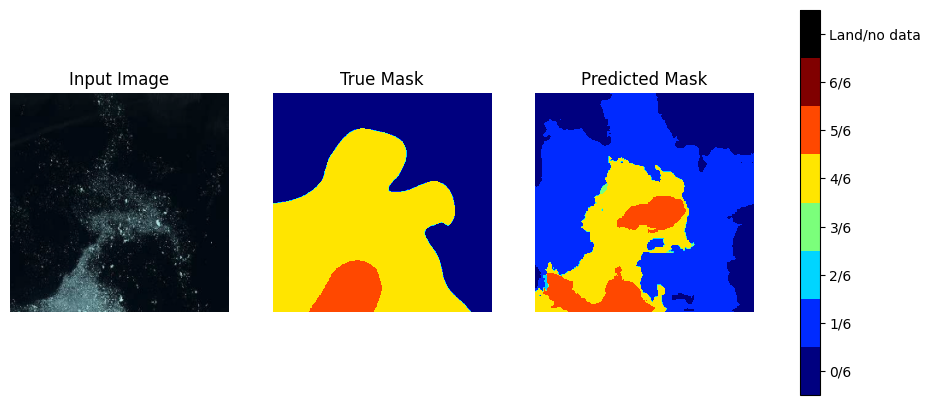

1/1 [==============================] - 2s 2s/step


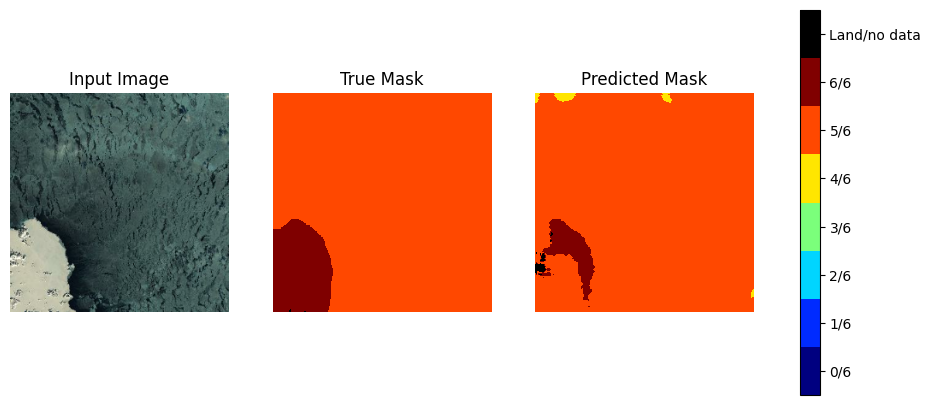

In [ ]:
random_val_dataset = val_dataset.shuffle(buffer_size=len(validation_names), seed=81).take(3) # 10, #1º 15

show_predictions(random_val_dataset, num=4, ele=3)

################

In [ ]:
#load weights for checkpoint 100
# print(os.listdir(checkpoint_dir))

model.load_weights(checkpoint_dir + '/cp-0100.ckpt')
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))


scores = model.evaluate(val_dataset, verbose=0)
print('Final Model Validation Scores')
print('Loss: {:.3f}'.format(scores[0]))
print('Accuracy: {:.3f}'.format(scores[1]))
print('IoU: {:.3f}'.format(scores[2]))

"scores = model.evaluate(val_dataset, verbose=0)\nprint('Final Model Validation Scores')\nprint('Loss: {:.3f}'.format(scores[0]))\nprint('Accuracy: {:.3f}'.format(scores[1]))\nprint('IoU: {:.3f}'.format(scores[2]))"

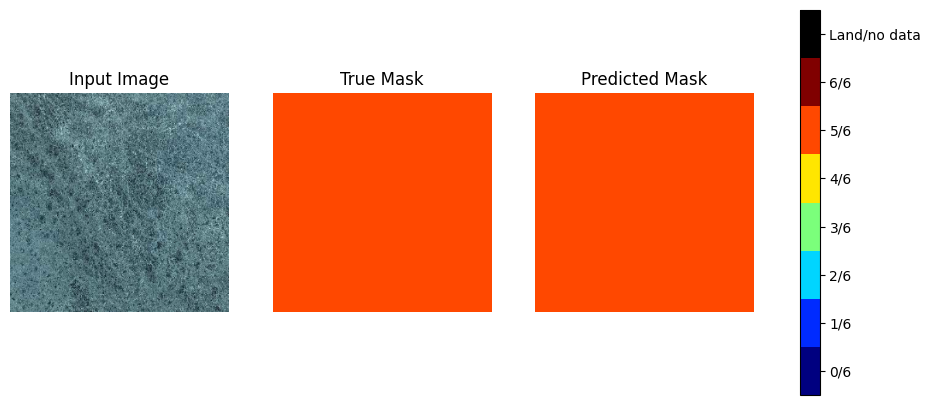

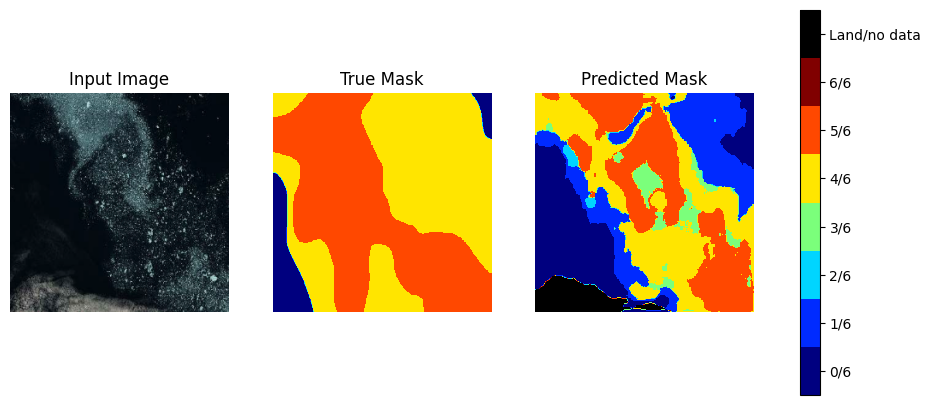

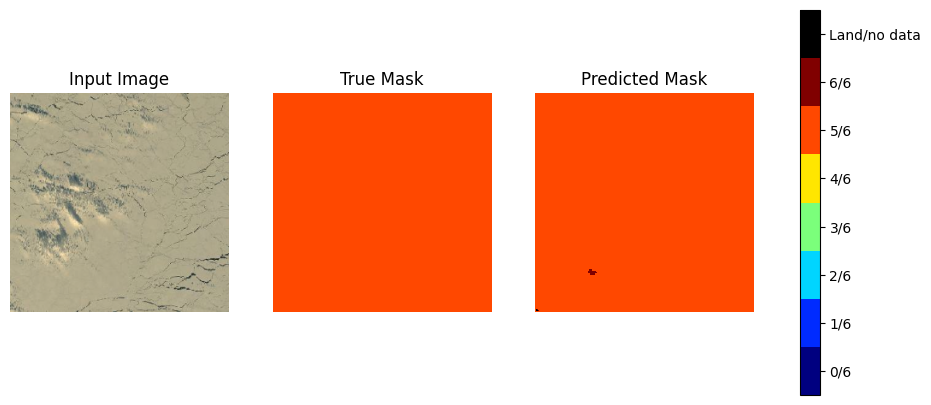

In [ ]:
random_val_dataset = val_dataset.shuffle(buffer_size=len(validation_names)).take(3)

show_predictions(random_val_dataset, num=4, ele=3)

### Consideraciones

Este script presenta una primera versión simplificada del modelo por limitaciones de recursos en kubeflow, y muestra aún margen de mejora si aumentásemos el número de épocas.

Se probará la versión completa del modelo incluyendo también data augmentation en un script diferente.

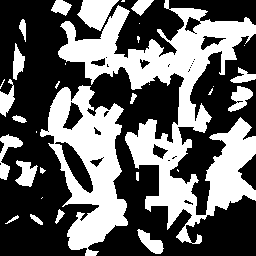

In [ ]:
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow

# Dimensiones de la máscara
height, width = 256, 256

# Crear una imagen en blanco como base de la máscara
mask = np.zeros((height, width), dtype=np.uint8)

# Número de formas geométricas
num_shapes = 300

# Generar formas geométricas al azar
for _ in range(num_shapes):
    shape_type = random.choice(['ellipse', 'rectangle'])
    shape_color = random.choice([0, 255])  # Color de la forma (0 para negro, 255 para blanco)
    shape_size = random.randint(5, 20)  # Tamaño de la forma

    if shape_type == 'ellipse':
        # Generar una elipse con posición, tamaño y excentricidad aleatorios
        center_x = random.randint(shape_size, width - shape_size)
        center_y = random.randint(shape_size, height - shape_size)
        angle = random.randint(0, 180)  # Ángulo de rotación de la elipse
        major_axis = random.randint(shape_size, int(shape_size * 2))  # Semieje mayor de la elipse
        minor_axis = random.randint(int(shape_size * 0.3), int(shape_size * 0.7))  # Semieje menor de la elipse
        cv2.ellipse(mask, (center_x, center_y), (major_axis, minor_axis), angle, 0, 360, shape_color, -1)
    else:
        # Generar un rectángulo con posición, tamaño y rotación aleatorios
        x = random.randint(0, width - shape_size)
        y = random.randint(0, height - shape_size * 2)  # Permitir rectángulos más altos
        width_rect = shape_size
        height_rect = random.randint(shape_size, shape_size * 3)  # Permitir rectángulos más altos
        angle_rect = random.randint(0, 45)  # Ángulo de rotación del rectángulo
        rect_points = cv2.boxPoints(((x, y), (width_rect, height_rect), angle_rect))
        rect_points = np.int0(rect_points)
        cv2.fillPoly(mask, [rect_points], shape_color)

# Visualizar la máscara
cv2_imshow(mask)




In [ ]:
pip install pillow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image, ImageDraw
import random

# Crea una nueva imagen en blanco
image = Image.new('RGB', (width, height), 'white')
draw = ImageDraw.Draw(image)

# Número y tamaño de las grietas
num_cracks = 200
min_crack_size = 2
max_crack_size = 20

# Genera las grietas
for _ in range(num_cracks):
    # Posición inicial y final de la grieta
    start_x = random.randint(0, width)
    start_y = random.randint(0, height)
    end_x = random.randint(0, width)
    end_y = random.randint(0, height)

    # Tamaño de la grieta
    crack_size = random.randint(min_crack_size, max_crack_size)

    # Dibuja la grieta como una línea curva
    draw.arc((start_x, start_y, end_x, end_y), 0, 360, fill='black', width=crack_size)


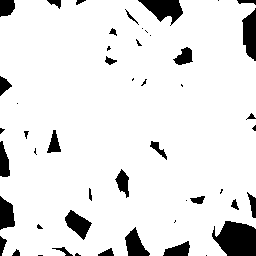

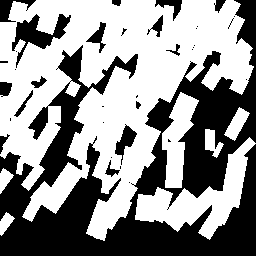

In [ ]:
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow

# Dimensiones de la máscara
height, width = 256, 256

# Crear una imagen en blanco como base de la máscara de elipses
mask_ellipses = np.zeros((height, width), dtype=np.uint8)

# Crear una imagen en blanco como base de la máscara de rectángulos
mask_rectangles = np.zeros((height, width), dtype=np.uint8)

# Número de formas geométricas
num_shapes_ellipses = 150
num_shapes_rectangles = 150

# Generar elipses aleatorias de alta excentricidad
for _ in range(num_shapes_ellipses):
    shape_color = random.choice([255])  # Color de la forma (0 para negro, 255 para blanco)
    shape_size = random.randint(5, 20)  # Tamaño de la forma

    center_x = random.randint(shape_size, width - shape_size)
    center_y = random.randint(shape_size, height - shape_size)
    angle = random.randint(0, 180)  # Ángulo de rotación de la elipse
    major_axis = random.randint(shape_size * 2, shape_size * 5)  # Semieje mayor de la elipse
    minor_axis = random.randint(int(shape_size * 0.5), int(shape_size * 0.8))  # Semieje menor de la elipse
    cv2.ellipse(mask_ellipses, (center_x, center_y), (major_axis, minor_axis), angle, 0, 360, shape_color, -1)

# Generar rectángulos rotados y al azar
for _ in range(num_shapes_rectangles):
    shape_color = random.choice([255])  # Color de la forma (0 para negro, 255 para blanco)
    shape_size = random.randint(5, 20)  # Tamaño de la forma

    x = random.randint(0, width - shape_size)
    y = random.randint(0, height - shape_size * 2)  # Permitir rectángulos más altos
    width_rect = shape_size
    height_rect = random.randint(shape_size, shape_size * 3)  # Permitir rectángulos más altos
    angle_rect = random.randint(0, 45)  # Ángulo de rotación del rectángulo
    rect_points = cv2.boxPoints(((x, y), (width_rect, height_rect), angle_rect))
    rect_points = np.int0(rect_points)
    cv2.fillPoly(mask_rectangles, [rect_points], shape_color)

# Visualizar la máscara de elipses
cv2_imshow(mask_ellipses)

# Visualizar la máscara de rectángulos
cv2_imshow(mask_rectangles)


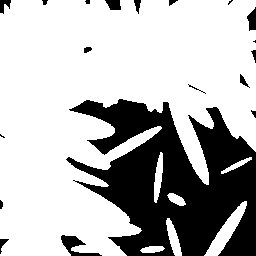

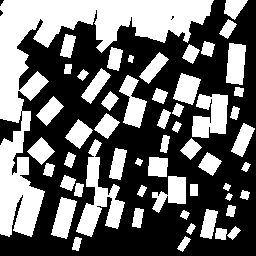

In [ ]:
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow

# Dimensiones de la máscara
height, width = 256, 256

# Crear una imagen en blanco como base de la máscara de elipses
mask_ellipses = np.zeros((height, width), dtype=np.uint8)

# Crear una imagen en blanco como base de la máscara de rectángulos
mask_rectangles = np.zeros((height, width), dtype=np.uint8)

# Número de formas geométricas
num_shapes_ellipses = 150
num_shapes_rectangles = 150

# Generar elipses aleatorias de alta excentricidad sin superposición
for _ in range(num_shapes_ellipses):
    shape_color = 255  # Color blanco (255)
    shape_size = random.randint(5, 20)  # Tamaño de la forma

    while True:
        center_x = random.randint(shape_size, width - shape_size)
        center_y = random.randint(shape_size, height - shape_size)
        angle = random.randint(0, 180)  # Ángulo de rotación de la elipse
        major_axis = random.randint(shape_size * 2, shape_size * 5)  # Semieje mayor de la elipse
        minor_axis = random.randint(int(shape_size * 0.5), int(shape_size * 0.8))  # Semieje menor de la elipse

        # Verificar si la elipse se superpone con otras figuras
        roi = mask_ellipses[center_y - major_axis: center_y + major_axis,
                            center_x - major_axis: center_x + major_axis]
        if np.any(roi == 255):
            continue

        cv2.ellipse(mask_ellipses, (center_x, center_y), (major_axis, minor_axis), angle, 0, 360, shape_color, -1)
        break

# Generar rectángulos rotados y al azar sin superposición
for _ in range(num_shapes_rectangles):
    shape_color = 255  # Color blanco (255)
    shape_size = random.randint(5, 20)  # Tamaño de la forma

    while True:
        x = random.randint(0, width - shape_size)
        y = random.randint(0, height - shape_size * 2)  # Permitir rectángulos más altos
        width_rect = shape_size
        height_rect = random.randint(shape_size, shape_size * 3)  # Permitir rectángulos más altos
        angle_rect = random.randint(0, 45)  # Ángulo de rotación del rectángulo

        rect_points = cv2.boxPoints(((x, y), (width_rect, height_rect), angle_rect))
        rect_points = np.int0(rect_points)

        # Verificar si el rectángulo se superpone con otras figuras
        roi = mask_rectangles[min(rect_points[:, 1]): max(rect_points[:, 1]),
                              min(rect_points[:, 0]): max(rect_points[:, 0])]
        if np.any(roi == 255):
            continue

        cv2.fillPoly(mask_rectangles, [rect_points], shape_color)
        break

# Visualizar la máscara de elipses
cv2_imshow(mask_ellipses)

# Visualizar la máscara de rectángulos
cv2_imshow(mask_rectangles)


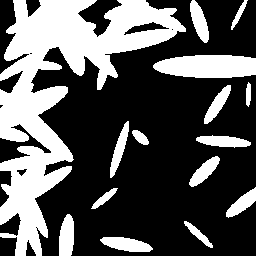

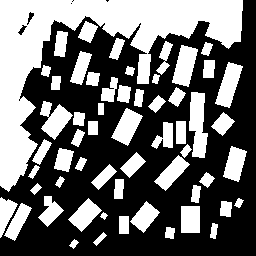

In [ ]:
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow

# Dimensiones de la máscara
height, width = 256, 256

# Crear una imagen en blanco como base de la máscara de elipses
mask_ellipses = np.zeros((height, width), dtype=np.uint8)

# Crear una imagen en blanco como base de la máscara de rectángulos
mask_rectangles = np.zeros((height, width), dtype=np.uint8)

# Número de formas geométricas
num_shapes_ellipses = 50
num_shapes_rectangles = 150

# Generar elipses aleatorias de alta excentricidad sin superposición
for _ in range(num_shapes_ellipses):
    shape_color = 255  # Color blanco (255)
    shape_size = random.randint(5, 15)  # Tamaño de la forma

    while True:
        center_x = random.randint(shape_size, width - shape_size)
        center_y = random.randint(shape_size, height - shape_size)
        angle = random.randint(0, 180)  # Ángulo de rotación de la elipse
        major_axis = random.randint(shape_size * 2, shape_size * 4)  # Semieje mayor de la elipse
        minor_axis = random.randint(int(shape_size * 0.5), int(shape_size * 0.8))  # Semieje menor de la elipse

        # Verificar si la elipse se superpone con otras figuras
        roi = mask_ellipses[center_y - major_axis: center_y + major_axis,
                            center_x - major_axis: center_x + major_axis]
        if np.any(roi == 255):
            continue

        cv2.ellipse(mask_ellipses, (center_x, center_y), (major_axis, minor_axis), angle, 0, 360, shape_color, -1)
        break

# Generar rectángulos rotados y al azar sin superposición
for _ in range(num_shapes_rectangles):
    shape_color = 255  # Color blanco (255)
    shape_size = random.randint(5, 20)  # Tamaño de la forma

    while True:
        x = random.randint(0, width - shape_size)
        y = random.randint(0, height - shape_size * 2)  # Permitir rectángulos más altos
        width_rect = shape_size
        height_rect = random.randint(shape_size, shape_size * 3)  # Permitir rectángulos más altos
        angle_rect = random.randint(0, 45)  # Ángulo de rotación del rectángulo

        rect_points = cv2.boxPoints(((x, y), (width_rect, height_rect), angle_rect))
        rect_points = np.int0(rect_points)

        # Verificar si el rectángulo se superpone con otras figuras
        roi = mask_rectangles[min(rect_points[:, 1]): max(rect_points[:, 1]),
                              min(rect_points[:, 0]): max(rect_points[:, 0])]
        if np.any(roi == 255):
            continue

        cv2.fillPoly(mask_rectangles, [rect_points], shape_color)
        break

# Visualizar la máscara de elipses
cv2_imshow(mask_ellipses)

# Visualizar la máscara de rectángulos
cv2_imshow(mask_rectangles)


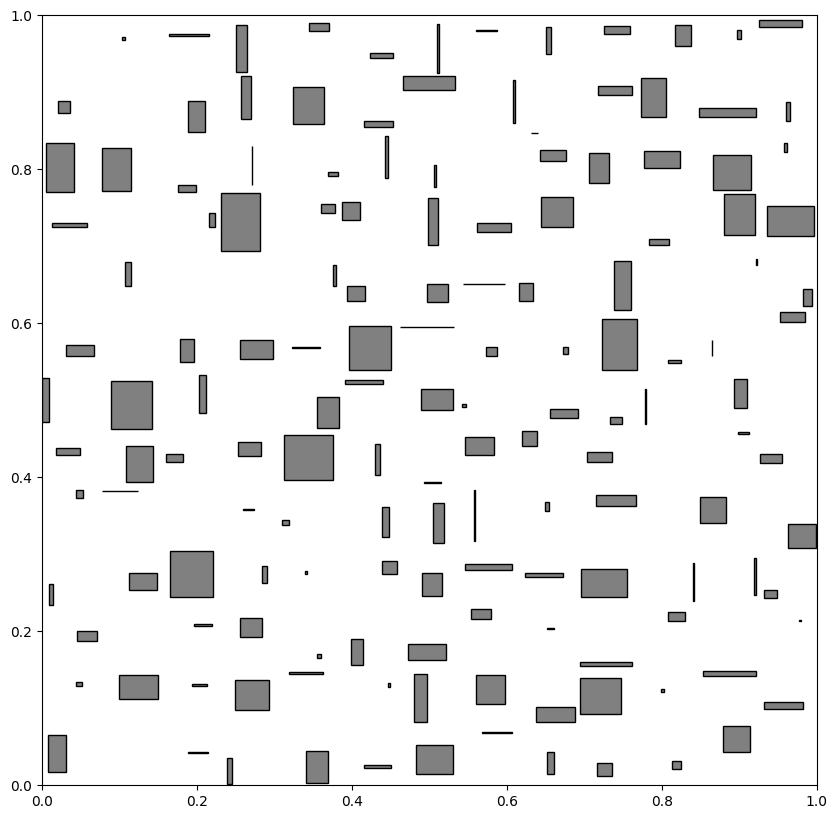

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from numpy.typing import ArrayLike
from numpy.random import default_rng
rng = default_rng(42069)


def get_rects(n: int) -> np.ndarray:
    """
    Params
    ------
    n: number of rectangles
    """
    ceilsqrtn = int(np.ceil(np.sqrt(n)))
    n_grids = ceilsqrtn * ceilsqrtn

    # Create rectangles in the "full space", that is the [0, 1] space
    rects = rng.uniform(size = (n, 4))

    # To ensure that the rectangles are in (x1, x2, y1, y2) format where
    # Upper left corner is (x1, y1) and bottom right corner (x2, y2)
    # Result looks fine without this, but it's a nice to have
    rects[:,:2].sort(1)
    rects[:,2:].sort(1)

    # Create a ceilsqrtn x ceilsqrtn even grid space
    flat_grid_indices = rng.choice(n_grids, n, False)
    offsets = np.unravel_index(flat_grid_indices, (ceilsqrtn, ceilsqrtn))

    # Move each rectangle into their own randomly assigned grid
    # This will result with rectangles in a space that is ceilsqrtn times larger than the [0, 1] space
    rects[:,:2] += offsets[1][..., None]
    rects[:,2:] += offsets[0][..., None]

    # Scale everything down to the [0, 1] space
    rects /= ceilsqrtn

    return rects


def plot_rects(rects: ArrayLike, width: int = 10, height: int = 10):
    fig, ax = plt.subplots(figsize=(width, height))
    for x1, x2, y1, y2 in rects:
        ax.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, facecolor='gray', edgecolor='black', fill=True))
    plt.show()

rects = get_rects(150)
plot_rects(rects)

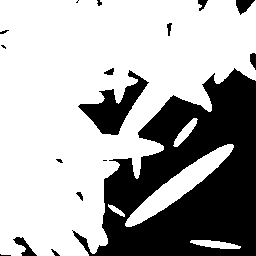

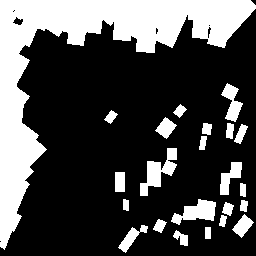

In [ ]:
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
# Dimensiones de la máscara
height, width = 256, 256

# Crear una imagen en blanco como base de la máscara de elipses
mask_ellipses = np.zeros((height, width), dtype=np.uint8)

# Crear una imagen en blanco como base de la máscara de rectángulos
mask_rectangles = np.zeros((height, width), dtype=np.uint8)

# Número de formas geométricas
num_shapes_ellipses = 150
num_shapes_rectangles = 150

# Generar elipses aleatorias de alta excentricidad sin superposición
for _ in range(num_shapes_ellipses):
    shape_color = 255  # Color blanco (255)
    shape_size = random.randint(5, 20)  # Tamaño de la forma

    while True:
        center_x = random.randint(shape_size, width - shape_size)
        center_y = random.randint(shape_size, height - shape_size)
        angle = random.randint(0, 180)  # Ángulo de rotación de la elipse
        major_axis = random.randint(shape_size * 2, shape_size * 5)  # Semieje mayor de la elipse
        minor_axis = random.randint(int(shape_size * 0.5), int(shape_size * 0.8))  # Semieje menor de la elipse

        # Verificar si la elipse se superpone con otras figuras
        roi = mask_ellipses[center_y - major_axis: center_y + major_axis,
                            center_x - major_axis: center_x + major_axis]
        if np.any(roi == 255):
            continue

        # Verificar si la elipse se superpone con los rectángulos
        roi = mask_rectangles[center_y - major_axis: center_y + major_axis,
                              center_x - major_axis: center_x + major_axis]
        if np.any(roi == 255):
            continue

        cv2.ellipse(mask_ellipses, (center_x, center_y), (major_axis, minor_axis), angle, 0, 360, shape_color, -1)
        break

# Generar rectángulos rotados y al azar sin superposición
for _ in range(num_shapes_rectangles):
    shape_color = 255  # Color blanco (255)
    shape_size = random.randint(5, 20)  # Tamaño de la forma

    while True:
        x = random.randint(0, width - shape_size)
        y = random.randint(0, height - shape_size * 2)  # Permitir rectángulos más altos
        width_rect = shape_size
        height_rect = random.randint(shape_size, shape_size * 3)  # Permitir rectángulos más altos
        angle_rect = random.randint(0, 45)  # Ángulo de rotación del rectángulo

        rect_points = cv2.boxPoints(((x, y), (width_rect, height_rect), angle_rect))
        rect_points = np.int0(rect_points)

        # Verificar si el rectángulo se superpone con otras figuras
        roi = mask_rectangles[min(rect_points[:, 1]): max(rect_points[:, 1]),
                              min(rect_points[:, 0]): max(rect_points[:, 0])]
        if np.any(roi == 255):
            continue

        # Verificar si el rectángulo se superpone con las elipses
        roi = mask_ellipses[min(rect_points[:, 1]): max(rect_points[:, 1]),
                            min(rect_points[:, 0]): max(rect_points[:, 0])]
        if np.any(roi == 255):
            continue

        cv2.fillPoly(mask_rectangles, [rect_points], shape_color)
        break

# Visualizar la máscara de elipses
cv2_imshow( mask_ellipses)


# Visualizar la máscara de rectángulos
cv2_imshow(mask_rectangles)


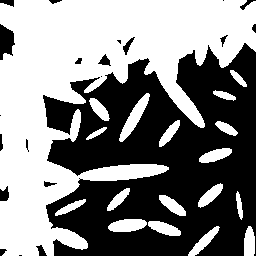

In [ ]:
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow

# Dimensiones de la máscara
height, width = 256, 256

# Crear una imagen en blanco como base de la máscara de elipses
mask_ellipses = np.zeros((height, width), dtype=np.uint8)

# Número de formas geométricas
num_shapes_ellipses = 150

shape_color = 255  # Color blanco (255)

# Generar elipses aleatorias de alta excentricidad sin superposición
for _ in range(num_shapes_ellipses):

    shape_size = random.randint(5, 15)  # Tamaño de la forma

    while True:
        center_x = random.randint(shape_size, width - shape_size)
        center_y = random.randint(shape_size, height - shape_size)
        angle = random.randint(0, 180)  # Ángulo de rotación de la elipse
        major_axis = random.randint(shape_size * 2, shape_size * 4)  # Semieje mayor de la elipse
        minor_axis = random.randint(int(shape_size * 0.5), int(shape_size * 0.8))  # Semieje menor de la elipse

        # Verificar si la elipse se superpone con otras figuras
        roi = mask_ellipses[center_y - major_axis: center_y + major_axis,
                            center_x - major_axis: center_x + major_axis]
        if np.any(roi == 255):
            continue

        cv2.ellipse(mask_ellipses, (center_x, center_y), (major_axis, minor_axis), angle, 0, 360, shape_color, -1)
        break

# Visualizar la máscara de elipses
cv2_imshow(mask_ellipses)



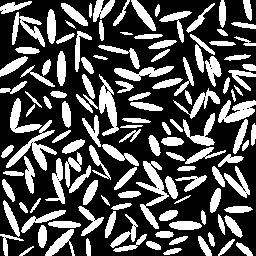

In [ ]:
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow

# Dimensiones de la máscara
height, width = 256, 256

# Crear una imagen en blanco como base de la máscara de elipses
mask_ellipses = np.zeros((height, width), dtype=np.uint8)
occupied_pixels = np.zeros((height, width), dtype=np.uint8)

# Número de formas geométricas
num_shapes_ellipses = 190

shape_color = 255  # Color blanco (255)

# Generar elipses aleatorias de alta excentricidad sin superposición
for _ in range(num_shapes_ellipses):
    shape_size = random.randint(3, 5)  # Tamaño de la forma

    while True:
        center_x = random.randint(shape_size, width - shape_size)
        center_y = random.randint(shape_size, height - shape_size)
        angle = random.randint(0, 180)  # Ángulo de rotación de la elipse
        major_axis = random.randint(shape_size * 2, shape_size * 4)  # Semieje mayor de la elipse
        minor_axis = random.randint(int(shape_size * 0.5), int(shape_size * 0.8))  # Semieje menor de la elipse

        # Crear una máscara temporal para la elipse
        ellipse_mask = np.zeros((height, width), dtype=np.uint8)
        cv2.ellipse(ellipse_mask, (center_x, center_y), (major_axis, minor_axis), angle, 0, 360, shape_color, -1)

        # Verificar si la elipse se superpone con otras figuras
        overlap = cv2.bitwise_and(occupied_pixels, ellipse_mask)
        if np.any(overlap == 255):
            continue

        cv2.ellipse(mask_ellipses, (center_x, center_y), (major_axis, minor_axis), angle, 0, 360, shape_color, -1)
        occupied_pixels = cv2.bitwise_or(occupied_pixels, ellipse_mask)
        break

# Visualizar la máscara de elipses
cv2_imshow(mask_ellipses)


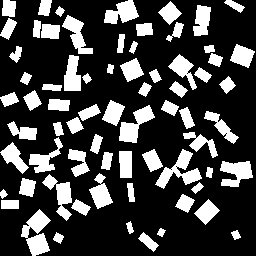

In [ ]:
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow

# Dimensiones de la máscara
height, width = 256, 256

# Crear una imagen en blanco como base de la máscara de rectángulos
mask_rectangles = np.zeros((height, width), dtype=np.uint8)
occupied_pixels = np.zeros((height, width), dtype=np.uint8)

# Número de formas geométricas
num_shapes_rectangles = 100

shape_color = 255  # Color blanco (255)

# Generar rectángulos aleatorios sin superposición
for _ in range(num_shapes_rectangles):
    min_side_length = 5
    max_side_length = 20

    while True:
        # Generar coordenadas aleatorias del rectángulo
        x1 = random.randint(0, width - max_side_length)
        y1 = random.randint(0, height - max_side_length)
        angle = random.randint(0, 180)  # Ángulo de rotación del rectángulo

        # Generar tamaño aleatorio para los lados del rectángulo
        side_length_1 = random.randint(min_side_length, max_side_length)
        side_length_2 = random.randint(min_side_length, max_side_length)

        # Calcular las coordenadas de los vértices del rectángulo
        rect_points = cv2.boxPoints(((x1 + side_length_1 / 2, y1 + side_length_2 / 2),
                                     (side_length_1, side_length_2), angle))
        rect_points = np.int0(rect_points)

        # Verificar si el rectángulo se superpone con otras figuras
        roi = occupied_pixels[y1:y1 + side_length_2, x1:x1 + side_length_1]
        if np.any(roi == 255):
            continue

        cv2.drawContours(mask_rectangles, [rect_points], 0, shape_color, -1)
        cv2.drawContours(occupied_pixels, [rect_points], 0, 255, -1)
        break

# Visualizar la máscara de rectángulos
cv2_imshow(mask_rectangles)


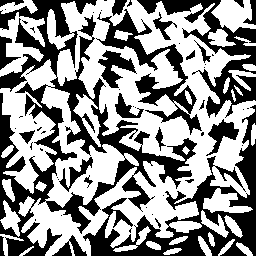

In [ ]:
# Realizar una operación OR bit a bit entre las máscaras
combined_mask = cv2.bitwise_or(mask_rectangles, mask_ellipses)

# Visualizar la máscara combinada
cv2_imshow(combined_mask)


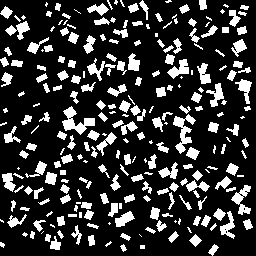

In [ ]:
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow

# Dimensiones de la máscara
height, width = 256, 256

# Crear una imagen en blanco como base de la máscara de figuras
mask_shapes = np.zeros((height, width), dtype=np.uint8)
occupied_pixels = np.zeros((height, width), dtype=np.uint8)

# Número de figuras geométricas
num_shapes = 350

# Colores para las figuras
shape_colors = [255]  # Puedes agregar más tonos si lo deseas

# Generar figuras aleatorias sin superposición
for _ in range(num_shapes):
    min_side_length = 1
    max_side_length = 10

    while True:
        # Generar coordenadas aleatorias de la figura
        x1 = random.randint(0, width - max_side_length)
        y1 = random.randint(0, height - max_side_length)
        angle = random.randint(0, 180)  # Ángulo de rotación de la figura

        # Generar tamaño aleatorio para los lados de la figura
        side_length_1 = random.randint(min_side_length, max_side_length)
        side_length_2 = random.randint(min_side_length, max_side_length)

        # Calcular las coordenadas de los vértices de la figura
        shape_points = cv2.boxPoints(((x1 + side_length_1 / 2, y1 + side_length_2 / 2),
                                      (side_length_1, side_length_2), angle))
        shape_points = np.int0(shape_points)

        # Verificar si la figura se superpone con otras figuras
        roi = occupied_pixels[y1:y1 + side_length_2, x1:x1 + side_length_1]
        if np.any(roi == 255):
            continue

        # Seleccionar un color aleatorio para la figura
        shape_color = random.choice(shape_colors)

        cv2.drawContours(mask_shapes, [shape_points], 0, shape_color, -1)
        cv2.drawContours(occupied_pixels, [shape_points], 0, 255, -1)
        break

# Visualizar la máscara de figuras
cv2_imshow(mask_shapes)

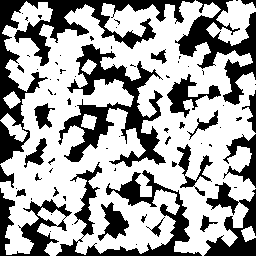

In [ ]:
height, width = 256, 256

# Crear una imagen en blanco como base de la máscara de figuras
mask_shapes2 = np.zeros((height, width), dtype=np.uint8)
occupied_pixels = np.zeros((height, width), dtype=np.uint8)

# Número de figuras geométricas
num_shapes2 = 300

# Colores para las figuras
shape_colors = [255]  # Puedes agregar más tonos si lo deseas

# Generar figuras aleatorias sin superposición
for _ in range(num_shapes):
    min_side_length = 9
    max_side_length = 12

    while True:
        # Generar coordenadas aleatorias de la figura
        x1 = random.randint(0, width - max_side_length)
        y1 = random.randint(0, height - max_side_length)
        angle = random.randint(0, 180)  # Ángulo de rotación de la figura

        # Generar tamaño aleatorio para los lados de la figura
        side_length_1 = random.randint(min_side_length, max_side_length)
        side_length_2 = random.randint(min_side_length, max_side_length)

        # Calcular las coordenadas de los vértices de la figura
        shape_points = cv2.boxPoints(((x1 + side_length_1 / 2, y1 + side_length_2 / 2),
                                      (side_length_1, side_length_2), angle))
        shape_points = np.int0(shape_points)



        # Seleccionar un color aleatorio para la figura
        shape_color = random.choice(shape_colors)

        cv2.drawContours(mask_shapes2, [shape_points], 0, shape_color, -1)
        cv2.drawContours(occupied_pixels, [shape_points], 0, 255, -1)
        break

# Visualizar la máscara de figuras
cv2_imshow(mask_shapes2)

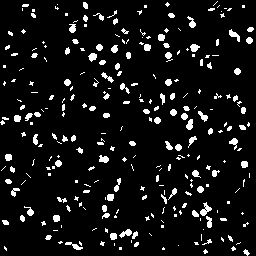

In [ ]:
# Dimensiones de la máscara
height, width = 256, 256

# Crear una imagen en blanco como base de la máscara de figuras
mask_ellipses = np.zeros((height, width), dtype=np.uint8)
occupied_pixels = np.zeros((height, width), dtype=np.uint8)

# Número de figuras geométricas
num_shapes = 350

# Colores para las figuras
shape_colors = [255]  # Puedes agregar más tonos si lo deseas

# Generar figuras aleatorias sin superposición
for _ in range(num_shapes):
    min_axis_length = 1
    max_axis_length = 7

    while True:
        # Generar coordenadas aleatorias de la figura
        x1 = random.randint(0, width - max_axis_length)
        y1 = random.randint(0, height - max_axis_length)

        # Generar tamaño aleatorio para los ejes de la elipse
        axis_length_1 = random.randint(min_axis_length, max_axis_length)
        axis_length_2 = random.randint(min_axis_length, max_axis_length)

        # Calcular las coordenadas de la elipse
        center = (x1 + axis_length_1 // 2, y1 + axis_length_2 // 2)
        axes = (axis_length_1 // 2, axis_length_2 // 2)
        angle = random.randint(0, 180)  # Ángulo de rotación de la elipse

        # Verificar si la figura se superpone con otras figuras

        # Seleccionar un color aleatorio para la figura
        shape_color = random.choice(shape_colors)

        cv2.ellipse(mask_ellipses, center, axes, angle, 0, 360, shape_color, -1)
        cv2.ellipse(occupied_pixels, center, axes, angle, 0, 360, 255, -1)
        break

# Visualizar la máscara de figuras
cv2_imshow(mask_ellipses)

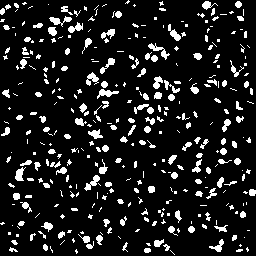

In [ ]:
height, width = 256, 256

# Crear una imagen en blanco como base de la máscara de figuras
mask_ellipses2 = np.zeros((height, width), dtype=np.uint8)
occupied_pixels = np.zeros((height, width), dtype=np.uint8)

# Número de figuras geométricas
num_shapes = 550

# Colores para las figuras
shape_colors = [255]  # Puedes agregar más tonos si lo deseas

# Generar figuras aleatorias sin superposición
for _ in range(num_shapes):
    min_axis_length = 1
    max_axis_length = 7

    while True:
        # Generar coordenadas aleatorias de la figura
        x1 = random.randint(0, width - max_axis_length)
        y1 = random.randint(0, height - max_axis_length)

        # Generar tamaño aleatorio para los ejes de la elipse
        axis_length_1 = random.randint(min_axis_length, max_axis_length)
        axis_length_2 = random.randint(min_axis_length, max_axis_length)

        # Calcular las coordenadas de la elipse
        center = (x1 + axis_length_1 // 2, y1 + axis_length_2 // 2)
        axes = (axis_length_1 // 2, axis_length_2 // 2)
        angle = random.randint(0, 180)  # Ángulo de rotación de la elipse

        # Verificar si la figura se superpone con otras figuras

        # Seleccionar un color aleatorio para la figura
        shape_color = random.choice(shape_colors)

        cv2.ellipse(mask_ellipses2, center, axes, angle, 0, 360, shape_color, -1)
        cv2.ellipse(occupied_pixels, center, axes, angle, 0, 360, 255, -1)
        break

# Visualizar la máscara de figuras
cv2_imshow(mask_ellipses2)

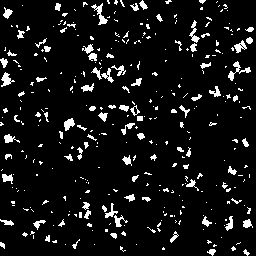

In [ ]:
# Realizar una operación OR bit a bit entre las máscaras
combined_mask = cv2.bitwise_or(mask_shapes, mask_ellipses)
result = cv2.subtract(combined_mask, mask_shapes2)

resultF = cv2.subtract(result, mask_ellipses2)

# Visualizar la máscara combinada
cv2_imshow(resultF)
